In [ ]:
# Load packages
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy

In [ ]:
pip install scikit-learn==1.2.2

In [ ]:
pip install scikit-survival==0.20.0

In [ ]:
from sksurv.ensemble import RandomSurvivalForest

In [ ]:
# adjusting figure resolution
plt.rcParams['figure.dpi'] = 300

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Read datasets needed (if using google drive)
feature_and_target = pd.read_csv('/content/drive/MyDrive/Predicting Loss of Autonomy/1. Swallowing/Jul 2022 PRO-ACT data (latest update)/Files/X_and_Y_with_NaNs.csv')

In [ ]:
feature_and_target.drop(['Unnamed: 0', 'SubjectID'], axis = 1, inplace = True)
feature_and_target

Age  Gender  diag_delta  onset_delta  onset_site  diag_minus_onset  \
0      7.0       0        9.93        16.47           0             -6.54   
1     10.0       0        1.45        33.63           1            -32.18   
2     12.0       0        1.61        16.90           0            -15.29   
3      5.0       1       16.80        18.74           0             -1.94   
4      8.0       0       12.43        25.08           0            -12.65   
...    ...     ...         ...          ...         ...               ...   
3391  11.0       1        1.08        33.24           0            -32.16   
3392   9.0       1        1.61        32.84           1            -31.23   
3393   6.0       1        7.63        12.16           0             -4.53   
3394   7.0       1        2.76        16.18           0            -13.42   
3395   8.0       0        8.88        10.88           0             -2.00   

      mean_Q1_Speech  mean_Q2_Salivation  mean_Q3_Swallowing  \
0               4.00            4.000000                4.00   
1               1.00            1.333333                2.00   
2               4.00            3.750000                3.25   
3               2.50            3.000000                3.00   
4               4.00            4.000000                4.00   
...              ...                 ...                 ...   
3391            3.00            3.500000                3.75   
3392            3.00            3.000000                4.00   
3393            4.00            4.000000                4.00   
3394            2.75            3.000000                2.75   
3395            3.00            4.000000                4.00   

      mean_Q4_Handwriting  ...  slope_motor  slope_respiratory_R    mean_fvc  \
0                3.500000  ...    -0.293851             0.000000         NaN   
1                4.000000  ...     0.770871             0.000000   73.451389   
2                4.000000  ...    -1.195652            -0.434783   89.400000   
3                1.500000  ...    -1.898734             0.632911   71.333333   
4                4.000000  ...          NaN                  NaN   85.790970   
...                   ...  ...          ...                  ...         ...   
3391             3.000000  ...    -0.824911             0.000000         NaN   
3392             4.000000  ...          NaN                  NaN   74.666667   
3393             4.000000  ...     0.000000             0.055136         NaN   
3394             4.000000  ...    -0.120494             0.000000  100.600000   
3395             0.666667  ...    -1.624528            -0.539561   84.916667   

      slope_fvc  mean_creatinine  slope_creatinine  mean_weight  slope_weight  \
0           NaN          53.0400          0.000000   120.033333      1.979045   
1           NaN          79.5600          0.000000    51.000000     -0.228993   
2     -1.283922              NaN               NaN    62.220000     -0.443537   
3      0.000000          58.4000         -0.703942   121.400000           NaN   
4           NaN          53.0400               NaN    88.900000     -1.500000   
...         ...              ...               ...          ...           ...   
3391        NaN          57.4725         -0.628392          NaN           NaN   
3392        NaN          83.9800          5.854305    84.750000           NaN   
3393        NaN          65.0000         -3.842884          NaN           NaN   
3394  -0.333391              NaN               NaN    70.460000     -0.618819   
3395   0.014113          48.6200         -2.542290    56.720000     -0.031719   

      time_LOA  status_LOA  
0        10.18         0.0  
1         6.44         1.0  
2         2.06         0.0  
3         5.02         1.0  
4         9.43         0.0  
...        ...         ...  
3391      1.41         0.0  
3392      9.82         0.0  
3393     10.78         0.0  
3394      3.05         0.0  
3395      1.14         0.0  

[3396 rows x 46 columns]

In [ ]:
# Check the proportion of censored data
event_distribution = pd.DataFrame(feature_and_target[['status_LOA']].value_counts()).reset_index()
event_distribution.columns = ['status', 'count']
event_distribution['status'] = event_distribution['status'].astype('bool')
event_distribution = event_distribution.replace({'status': {False:'0 (censored)', True:'1 (occured)'}})
print(event_distribution)   # 2781 censored, 615 uncensored  (82% censored)

         status  count
0  0 (censored)   2781
1   1 (occured)    615


# 0. Data Normalization & Imputation for feature selection

In [ ]:
from sklearn.preprocessing import RobustScaler

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import linear_model

In [ ]:
# Drop features with NaN proportion > 40% : ['slope_fvc', 'slope_Creatinine', 'slope_weight'] is excluded
X_y_NaN = feature_and_target.copy()
X_y_NaN.drop(['slope_fvc', 'slope_creatinine', 'slope_weight'], axis=1, inplace=True)

In [ ]:
# Scaling with RobustScaler
categorical_and_y = X_y_NaN[['Gender', 'onset_site','time_LOA', 'status_LOA']]
X_continuous_NaN = X_y_NaN.drop(['Gender', 'onset_site','time_LOA', 'status_LOA'], axis = 1)
columns = X_continuous_NaN.columns
scaler = RobustScaler()
scaled = scaler.fit_transform(X_continuous_NaN)
X_continuous_scaled = pd.DataFrame(scaled, columns = columns)
X_y_scaled = pd.concat([X_continuous_scaled, categorical_and_y],axis=1)
X_y_scaled

Age  diag_delta  onset_delta  diag_minus_onset  mean_Q1_Speech  \
0    -0.333333    0.528941    -0.044269          0.317178            0.50   
1     0.666667   -0.515394     1.312253         -2.828834           -2.50   
2     1.333333   -0.495690    -0.010277         -0.756442            0.50   
3    -1.000000    1.375000     0.135178          0.881595           -1.00   
4     0.000000    0.836823     0.636364         -0.432515            0.50   
...        ...         ...          ...               ...             ...   
3391  1.000000   -0.560961     1.281423         -2.826380           -0.50   
3392  0.333333   -0.495690     1.249802         -2.712270           -0.50   
3393 -0.666667    0.245690    -0.384980          0.563804            0.50   
3394 -0.333333   -0.354064    -0.067194         -0.526994           -0.75   
3395  0.000000    0.399631    -0.486166          0.874233           -0.50   

      mean_Q2_Salivation  mean_Q3_Swallowing  mean_Q4_Handwriting  \
0               0.000000                0.00             0.393443   
1              -2.666667               -2.00             0.786885   
2              -0.250000               -0.75             0.786885   
3              -1.000000               -1.00            -1.180328   
4               0.000000                0.00             0.786885   
...                  ...                 ...                  ...   
3391           -0.500000               -0.25             0.000000   
3392           -1.000000                0.00             0.786885   
3393            0.000000                0.00             0.786885   
3394           -1.000000               -1.25             0.786885   
3395            0.000000                0.00            -1.836066   

      mean_Q6_Dressing_and_Hygiene  mean_Q7_Turning_in_Bed  ...  slope_bulbar  \
0                        -0.250000                0.333333  ...      0.000000   
1                         0.833333                0.666667  ...     -5.351714   
2                         0.250000                0.666667  ...      3.546674   
3                        -1.500000               -1.666667  ...     -6.883840   
4                        -0.500000                0.000000  ...           NaN   
...                            ...                     ...  ...           ...   
3391                      0.250000               -0.666667  ...      3.320390   
3392                      1.500000                0.000000  ...           NaN   
3393                      0.500000                0.000000  ...      0.000000   
3394                      0.500000                0.666667  ...     -7.121953   
3395                     -1.500000               -1.111111  ...      0.000000   

      slope_motor  slope_respiratory_R  mean_fvc  mean_creatinine  \
0        0.166066             0.000000       NaN        -0.494151   
1        1.145610             0.000000 -0.446361         0.564743   
2       -0.663592           -18.550000  0.274028              NaN   
3       -1.310427            27.003165 -0.542033        -0.280136   
4             NaN                  NaN  0.111010        -0.494151   
...           ...                  ...       ...              ...   
3391    -0.322510             0.000000       NaN        -0.317169   
3392          NaN                  NaN -0.391468         0.741226   
3393     0.436408             2.352391       NaN        -0.016610   
3394     0.325554             0.000000  0.779925              NaN   
3395    -1.058157           -23.020385  0.071518        -0.670633   

      mean_weight  Gender  onset_site  time_LOA  status_LOA  
0        1.984367       0           0     10.18         0.0  
1       -1.221268       0           1      6.44         1.0  
2       -0.700255       0           0      2.06         0.0  
3        2.047829       1           0      5.02         1.0  
4        0.538658       0           0      9.43         0.0  
...           ...     ...         ...       ...         ...  
3391          NaN    

In [ ]:
X_y_scaled.describe()

Age    diag_delta  onset_delta  diag_minus_onset  \
count  3396.000000  3.396000e+03  3396.000000       3396.000000   
mean     -0.085296  3.120188e-01     0.196489         -0.272638   
std       0.749813  1.046770e+00     0.963531          1.082189   
min      -2.666667 -6.939655e-01    -1.164427        -11.276687   
25%      -0.666667 -3.663793e-01    -0.436364         -0.603067   
50%       0.000000  5.464379e-17     0.000000          0.000000   
75%       0.333333  6.336207e-01     0.563636          0.396933   
max       2.000000  2.020259e+01    15.864032          1.119632   

       mean_Q1_Speech  mean_Q2_Salivation  mean_Q3_Swallowing  \
count     3396.000000         3396.000000         3396.000000   
mean        -0.225412           -0.476644           -0.439856   
std          0.875567            0.710993            0.592431   
min         -3.500000           -4.000000           -2.000000   
25%         -0.500000           -1.000000           -1.000000   
50%          0.000000            0.000000            0.000000   
75%          0.500000            0.000000            0.000000   
max          0.500000            0.000000            0.000000   

       mean_Q4_Handwriting  mean_Q6_Dressing_and_Hygiene  \
count          3396.000000                   3396.000000   
mean             -0.023024                     -0.047448   
std               0.768144                      0.965964   
min              -2.360656                     -2.500000   
25%              -0.213115                     -0.500000   
50%               0.000000                      0.000000   
75%               0.786885                      0.500000   
max               0.786885                      1.500000   

       mean_Q7_Turning_in_Bed  ...  slope_bulbar  slope_motor  \
count             3396.000000  ...   2921.000000  2921.000000   
mean                 0.016788  ...     -0.835061    -0.109958   
std                  0.604713  ...      3.388058     0.857088   
min                 -2.000000  ...    -17.733370    -4.943709   
25%                 -0.333333  ...     -1.000000    -0.563592   
50%                  0.000000  ...      0.000000     0.000000   
75%                  0.666667  ...      0.000000     0.436408   
max                  0.666667  ...     14.114841     3.080086   

       slope_respiratory_R     mean_fvc  mean_creatinine  mean_weight  \
count          2921.000000  2141.000000      3039.000000  2630.000000   
mean             -4.811746     0.058895         0.056845     0.093247   
std              20.895913     0.742023         0.710818     0.937737   
min            -192.680645    -2.085320        -1.906009    -3.250522   
25%              -1.000000    -0.461731        -0.493751    -0.476434   
50%               0.000000     0.000000         0.000000     0.000000   
75%               0.000000     0.538269         0.506249     0.523566   
max             141.430939     2.573286         5.859213     8.545778   

            Gender   onset_site     time_LOA   status_LOA  
count  3396.000000  3396.000000  3396.000000  3396.000000  
mean      0.644876     0.180212     7.522064     0.181095  
std       0.478621     0.384421     5.964656     0.385154  
min       0.000000     0.000000     0.020000     0.000000  
25%       0.000000     0.000000     2.950000     0.000000  
50%       1.000000     0.000000     7.750000     0.000000  
75%       1.000000     0.000000    10.180000     0.000000  
max       1.000000     1.000000    66.500000     1.000000  

[8 rows x 43 columns]

In [ ]:
# Imputation with IterativeImputer
y = X_y_scaled[['time_LOA', 'status_LOA']]
X_NaN = X_y_scaled.drop(['time_LOA', 'status_LOA'], axis = 1)
columns = X_NaN.columns
imputer = IterativeImputer(sample_posterior = True, random_state=11)
ar = imputer.fit_transform(X_NaN)
X_imputed = pd.DataFrame(ar, columns = columns)
X_y_scaled_imputed = pd.concat([X_imputed, y],axis=1)
X_y_scaled_imputed

Age  diag_delta  onset_delta  diag_minus_onset  mean_Q1_Speech  \
0    -0.333333    0.528941    -0.044269          0.317178            0.50   
1     0.666667   -0.515394     1.312253         -2.828834           -2.50   
2     1.333333   -0.495690    -0.010277         -0.756442            0.50   
3    -1.000000    1.375000     0.135178          0.881595           -1.00   
4     0.000000    0.836823     0.636364         -0.432515            0.50   
...        ...         ...          ...               ...             ...   
3391  1.000000   -0.560961     1.281423         -2.826380           -0.50   
3392  0.333333   -0.495690     1.249802         -2.712270           -0.50   
3393 -0.666667    0.245690    -0.384980          0.563804            0.50   
3394 -0.333333   -0.354064    -0.067194         -0.526994           -0.75   
3395  0.000000    0.399631    -0.486166          0.874233           -0.50   

      mean_Q2_Salivation  mean_Q3_Swallowing  mean_Q4_Handwriting  \
0               0.000000                0.00             0.393443   
1              -2.666667               -2.00             0.786885   
2              -0.250000               -0.75             0.786885   
3              -1.000000               -1.00            -1.180328   
4               0.000000                0.00             0.786885   
...                  ...                 ...                  ...   
3391           -0.500000               -0.25             0.000000   
3392           -1.000000                0.00             0.786885   
3393            0.000000                0.00             0.786885   
3394           -1.000000               -1.25             0.786885   
3395            0.000000                0.00            -1.836066   

      mean_Q6_Dressing_and_Hygiene  mean_Q7_Turning_in_Bed  ...  slope_bulbar  \
0                        -0.250000                0.333333  ...  0.000000e+00   
1                         0.833333                0.666667  ... -5.351714e+00   
2                         0.250000                0.666667  ...  3.546674e+00   
3                        -1.500000               -1.666667  ... -6.883840e+00   
4                        -0.500000                0.000000  ...  1.353454e+15   
...                            ...                     ...  ...           ...   
3391                      0.250000               -0.666667  ...  3.320390e+00   
3392                      1.500000                0.000000  ...  5.987575e+14   
3393                      0.500000                0.000000  ...  0.000000e+00   
3394                      0.500000                0.666667  ... -7.121953e+00   
3395                     -1.500000               -1.111111  ...  0.000000e+00   

       slope_motor  slope_respiratory_R  mean_fvc  mean_creatinine  \
0     1.660658e-01         0.000000e+00  0.396470        -0.494151   
1     1.145610e+00         0.000000e+00 -0.446361         0.564743   
2    -6.635917e-01        -1.855000e+01  0.274028         1.081984   
3    -1.310427e+00         2.700316e+01 -0.542033        -0.280136   
4    -1.099860e+12         1.645437e+16  0.111010        -0.494151   
...            ...                  ...       ...              ...   
3391 -3.225099e-01         0.000000e+00 -0.891709        -0.317169   
3392  4.224267e+13         5.103128e+15 -0.391468         0.741226   
3393  4.364083e-01         2.352391e+00 -0.526028        -0.016610   
3394  3.255541e-01         0.000000e+00  0.779925        -0.036327   
3395 -1.058157e+00        -2.302038e+01  0.071518        -0.670633   

      mean_weight  Gender  onset_site  time_LOA  status_LOA  
0        1.984367     0.0         0.0     10.18         0.0  
1       -1.221268     0.0         1.0      6.44         1.0  
2       -0.700255     0.0         0.0      2.06         0.0  
3        2.047829     1.0         0.0      5.02         1.0  
4        0.538658     0.0         0.0      9.43         0.0  
...           ...     ...         ...       ...         ...  
3391     

In [ ]:
# Imputation with IterativeImputer for RSF (no need scaling process)
y = X_y_NaN[['time_LOA', 'status_LOA']]
X_NaN = X_y_NaN.drop(['time_LOA', 'status_LOA'], axis = 1)
columns = X_NaN.columns
imputer = IterativeImputer(sample_posterior = True, random_state=11)
ar = imputer.fit_transform(X_NaN)
X_imputed = pd.DataFrame(ar, columns = columns)
X_y_imputed = pd.concat([X_imputed, y],axis=1)
X_y_imputed

Age  Gender  diag_delta  onset_delta  onset_site  diag_minus_onset  \
0      7.0     0.0        9.93        16.47         0.0             -6.54   
1     10.0     0.0        1.45        33.63         1.0            -32.18   
2     12.0     0.0        1.61        16.90         0.0            -15.29   
3      5.0     1.0       16.80        18.74         0.0             -1.94   
4      8.0     0.0       12.43        25.08         0.0            -12.65   
...    ...     ...         ...          ...         ...               ...   
3391  11.0     1.0        1.08        33.24         0.0            -32.16   
3392   9.0     1.0        1.61        32.84         1.0            -31.23   
3393   6.0     1.0        7.63        12.16         0.0             -4.53   
3394   7.0     1.0        2.76        16.18         0.0            -13.42   
3395   8.0     0.0        8.88        10.88         0.0             -2.00   

      mean_Q1_Speech  mean_Q2_Salivation  mean_Q3_Swallowing  \
0               4.00            4.000000                4.00   
1               1.00            1.333333                2.00   
2               4.00            3.750000                3.25   
3               2.50            3.000000                3.00   
4               4.00            4.000000                4.00   
...              ...                 ...                 ...   
3391            3.00            3.500000                3.75   
3392            3.00            3.000000                4.00   
3393            4.00            4.000000                4.00   
3394            2.75            3.000000                2.75   
3395            3.00            4.000000                4.00   

      mean_Q4_Handwriting  ...  slope_R3_Respiratory_Insufficiency  \
0                3.500000  ...                            0.000000   
1                4.000000  ...                            0.000000   
2                4.000000  ...                            0.000000   
3                1.500000  ...                            0.000000   
4                4.000000  ...                           -0.018600   
...                   ...  ...                                 ...   
3391             3.000000  ...                            0.000000   
3392             4.000000  ...                           -0.018545   
3393             4.000000  ...                            0.000000   
3394             4.000000  ...                            0.000000   
3395             0.666667  ...                            0.000000   

      slope_Q5_Cutting  slope_bulbar  slope_motor  slope_respiratory_R  \
0             0.000000      0.000000    -0.293851             0.000000   
1             0.000000     -0.492045     0.770871             0.000000   
2             0.000000      0.326087    -1.195652            -0.434783   
3             0.000000     -0.632911    -1.898734             0.632911   
4            -0.108873     -0.076878    -0.593881            -0.112826   
...                ...           ...          ...                  ...   
3391          0.352049      0.305282    -0.824911             0.000000   
3392         -0.108962     -0.076995    -0.593611            -0.112593   
3393          0.000000      0.000000     0.000000             0.055136   
3394         -0.120494     -0.654804    -0.120494             0.000000   
3395          0.000000      0.000000    -1.624528            -0.539561   

        mean_fvc  mean_creatinine  mean_weight  time_LOA  status_LOA  
0      91.358158        53.040000   120.033333     10.18         0.0  
1      73.451389        79.560000    51.000000      6.44         1.0  
2      89.400000        81.220130    62.220000      2.06         0.0  
3      71.333333        58.400000   121.400000      5.02         1.0  
4      85.790970        53.040000    88.900000      9.43         0.0  
...          ...              ...          ...       ...         ...  
3391   63.625296        57.472500   107.665601      1.41         0.0  
3392   74.66666

In [ ]:
df_for_featsel = X_y_scaled_imputed.copy()
df_for_featsel_rsf = X_y_imputed.copy()

# 1.  Embedded method

In [ ]:
pip install lifelines

##1-1. AFT

### (1) Hyperparameter tuning with GridSearchCV

In [ ]:
# Hyperparameter tuning for lasso
from sklearn.model_selection import GridSearchCV

aft_params ={ 'penalizer': [1e-4, 0.00005, 1e-3, 0.005, 1e-2, 0.05, 0.1, 0.15, 0.2, 0.35,0.5],
              'l1_ratio' : [1]  }

In [ ]:
# CAUTION! Runtime takes more than 5mins
from lifelines import WeibullAFTFitter
from lifelines.utils.sklearn_adapter import sklearn_adapter
from sklearn.model_selection import KFold

X_aft = df_for_featsel.drop(columns = 'time_LOA')
y_aft = df_for_featsel['time_LOA']

base_class2 = sklearn_adapter(WeibullAFTFitter, event_col = 'status_LOA')
aft = base_class2()

grid_cv1 = GridSearchCV(aft, param_grid = aft_params, cv = KFold(n_splits = 3), n_jobs = 1)
grid_cv1.fit(X_aft, y_aft)

/usr/local/lib/python3.10/dist-packages/lifelines/fitters/__init__.py:2097: StatisticalWarning: The diagonal of the variance_matrix_ has negative values. This could be a problem with WeibullAFTFitter's fit to the data.

It's advisable to not trust the variances reported, and to be suspicious of the fitted parameters too.

  warnings.warn(warning_text, exceptions.StatisticalWarning)
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/__init__.py:2097: StatisticalWarning: The diagonal of the variance_matrix_ has negative values. This could be a problem with WeibullAFTFitter's fit to the data.

It's advisable to not trust the variances reported, and to be suspicious of the fitted parameters too.

  warnings.warn(warning_text, exceptions.StatisticalWarning)
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/__init__.py:2097: StatisticalWarning: The diagonal of the variance_matrix_ has negative values. This could be a problem with WeibullAFTFitter's fit to the data.

It's advis

GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
             estimator=SkLearnWeibullAFTFitter(alpha=0.05, fit_intercept=True,
                                               l1_ratio=0.0,
                                               model_ancillary=False,
                                               penalizer=0.0),
             n_jobs=1,
             param_grid={'l1_ratio': [1],
                         'penalizer': [0.0001, 5e-05, 0.001, 0.005, 0.01, 0.05,
                                       0.1, 0.15, 0.2, 0.35, 0.5]})

In [ ]:
# Result
print(grid_cv1.best_score_)  # 0.8424573789320643
print(grid_cv1.best_params_)  # {'l1_ratio': 1, 'penalizer': 0.01} is selected

0.8424573789320643
{'l1_ratio': 1, 'penalizer': 0.01}


In [ ]:
# Result
cv_results = grid_cv1.cv_results_
cv_results

{'mean_fit_time': array([3.61043247, 1.74836429, 4.04067548, 4.15583078, 4.57142981,
        6.42051291, 8.72842137, 7.57563837, 1.33726112, 0.72027254,
        0.97249937]),
 'std_fit_time': array([1.38397279, 0.14358426, 0.88227038, 2.48876295, 1.14866727,
        1.58892314, 2.38318358, 0.79029469, 0.23763948, 0.0089214 ,
        0.23649654]),
 'mean_score_time': array([0.04177348, 0.02885429, 0.04920189, 0.03733778, 0.02889355,
        0.03984801, 0.        , 0.00959969, 0.03107866, 0.03110679,
        0.06448388]),
 'std_score_time': array([0.01944072, 0.00036409, 0.01544666, 0.01268127, 0.0002581 ,
        0.01657735, 0.        , 0.01357601, 0.00244979, 0.00260981,
        0.00566325]),
 'param_l1_ratio': masked_array(data=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False],
        fill_value='?',
             dtype=object),
 'param_penalizer': masked_array(data=[0.0001, 5e-05, 0.

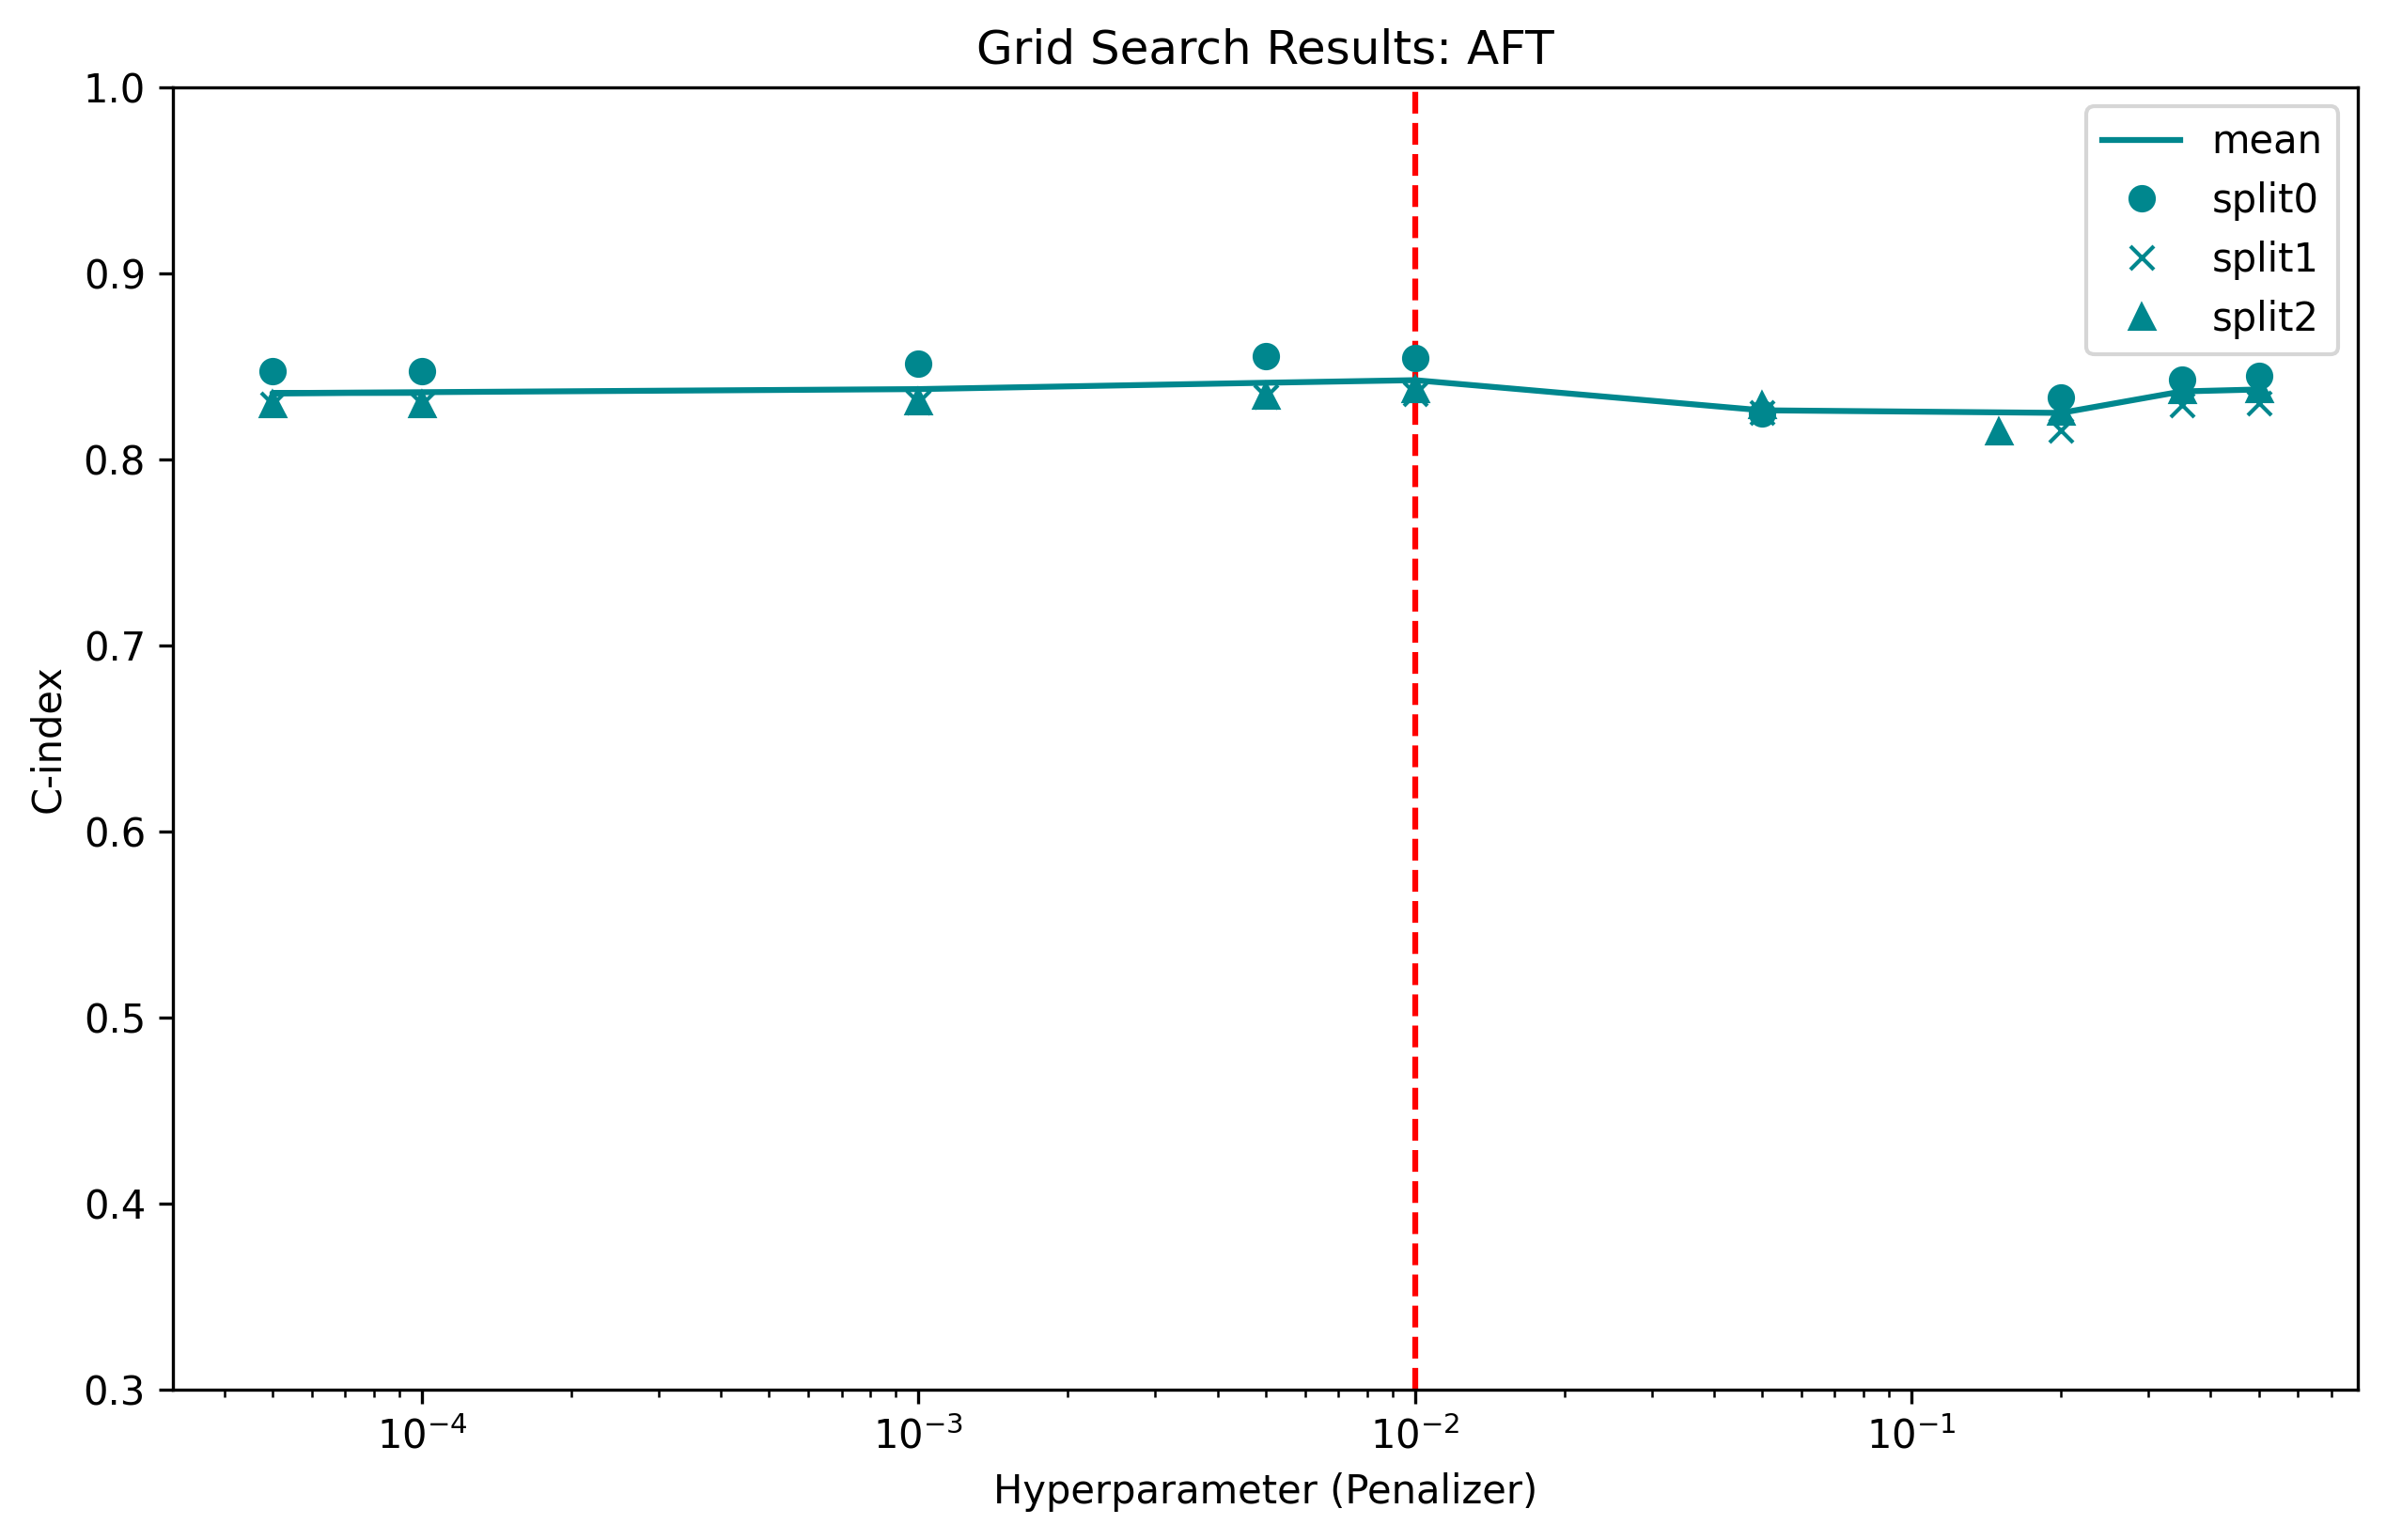

In [ ]:
cv_results = grid_cv1.cv_results_
cv_results['param_penalizer'] = np.asarray(cv_results['param_penalizer'])

# Remove NaN values
valid0 = ~np.isnan(cv_results['split0_test_score'])
valid1 = ~np.isnan(cv_results['split1_test_score'])
valid2 = ~np.isnan(cv_results['split2_test_score'])

fig, ax = plt.subplots(figsize=(10, 6))
ax.axvline(x=0.01, color='red', linestyle='--')  # Penalizer = 0.01 showed best score

# Drop the indices with NaN values in all splits (indices 6 and 7)
drop_indices = [6, 7]
ax.plot(pd.DataFrame(cv_results)['param_penalizer'].drop(index=drop_indices),
        pd.DataFrame(cv_results)[['split0_test_score', 'split1_test_score', 'split2_test_score']].mean(axis=1, skipna=True).drop(index=drop_indices),
        '-', label='mean', color='#00878E')

ax.plot(cv_results['param_penalizer'][valid0], cv_results['split0_test_score'][valid0], 'o', label='split0', color='#00878E')
ax.plot(cv_results['param_penalizer'][valid1], cv_results['split1_test_score'][valid1], 'x', label='split1', color='#00878E')
ax.plot(cv_results['param_penalizer'][valid2], cv_results['split2_test_score'][valid2], '^', label='split2', color='#00878E')

ax.set_xscale('log')
ax.set_xlabel('Hyperparameter (Penalizer)')
ax.set_ylabel('C-index')
ax.set_title('Grid Search Results: AFT')
plt.ylim([0.3, 1.0])
plt.legend()
plt.show()

### (2) Feature selection with Lasso

In [ ]:
# Fit model with selected hyperparameter & print summary
from lifelines import WeibullAFTFitter

aft = WeibullAFTFitter(penalizer = 0.01, l1_ratio = 1)
aft.fit(df_for_featsel, duration_col='time_LOA', event_col='status_LOA', ancillary=False)

aft.print_summary() # Prints accelerated failure rate & p-value of each feature

/usr/local/lib/python3.10/dist-packages/lifelines/fitters/__init__.py:2097: StatisticalWarning: The diagonal of the variance_matrix_ has negative values. This could be a problem with WeibullAFTFitter's fit to the data.

It's advisable to not trust the variances reported, and to be suspicious of the fitted parameters too.

  warnings.warn(warning_text, exceptions.StatisticalWarning)


<lifelines.WeibullAFTFitter: fitted with 3396 total observations, 2781 right-censored observations>
             duration col = 'time_LOA'
                event col = 'status_LOA'
                penalizer = 0.01
   number of observations = 3396
number of events observed = 615
           log-likelihood = -2530.79
         time fit was run = 2023-11-22 14:07:02 UTC

---
                                             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param   covariate                                                                                                                                  
lambda_ Age                                 -0.21       0.81       0.04            -0.29            -0.14                 0.75                 0.87
        Gender                               0.00       1.00       0.07            -0.13             0.13                 0.88                 1.14
        diag_delta                           0.06       1.07 1084497.45      -2125575.87       2125576.00                 0.00                  inf
        diag_minus_onset                    -0.00       1.00 1088504.21      -2133429.05       2133429.05                 0.00                  inf
        mean_ALSFRS_R_Total                 -0.00       1.00   35366.89        -69317.84         69317.84                 0.00                  inf
        mean_Q1_Speech                       0.00       1.00        NaN              NaN              NaN                  NaN                  NaN
        mean_Q2_Salivation                   0.09       1.09    4715.59         -9242.29          9242.47                 0.00                  inf
        mean_Q3_Swallowing                   0.15       1.16        NaN              NaN              NaN                  NaN                  NaN
        mean_Q4_Handwriting                 -0.00       1.00   81047.96       -158851.08        158851.08                 0.00                  inf
        mean_Q5_Cutting                      0.07       1.07  106292.40       -208329.22        208329.35                 0.00                  inf
        mean_Q6_Dressing_and_Hygiene         0.00       1.00   63775.44       -124997.57        124997.57                 0.00                  inf
        mean_Q7_Turning_in_Bed               0.16       1.17   95663.16       -187496.20        187496.51                 0.00                  inf
        mean_Q8_Walking                      0.00       1.00   89285.62       -174996.60        174996.60                 0.00                  inf
        mean_Q9_Climbing_Stairs              0.00       1.00  127550.88       -249995.14        249995.14                 0.00                  inf
        mean_R1_Dyspnea                      0.00       1.00  245962.81       -482078.25        482078.25                 0.00                  inf
        mean_R2_Orthopnea                    0.00       1.00  327950.41       -642771.00        642771.00                 0.00                  inf
        mean_R3_Respiratory_Insufficiency   -0.02       0.98  327950.41       -642771.02        642770.98                 0.00                  inf
        mean_bulbar                          0.60       1.83        NaN              NaN              NaN                  NaN                  NaN
        mean_creatinine                      0.08       1.09       0.05            -0.01             0.18                 0.99                 1.20
        mean_fvc                             0.13       1.14       0.04             0.05             0.21                 1.05                 1.23
        mean_motor                           0.00       1.00  402601.55       -789084.54        789084.54                 0.00                  inf
        mean_respiratory_R                  -0.00       1.00  328014.44       -642896.48        642896.48                 0.00                  inf
        mean_weight                          0.05       1.06       0.03     

In [ ]:
# Print coefficients in order of size
aft_coef = aft.params_.copy()
aft_coef.index = aft_coef.index.droplevel()
df_aft_coef = pd.DataFrame(aft_coef, columns=['coefficient'])
df_aft_coef.reset_index(inplace=True)
df_aft_coef= df_aft_coef.query('covariate != "Intercept"')
df_aft_coef.sort_values(by='coefficient', ascending=True, inplace=True)
df_aft_coef

covariate   coefficient
0                                  Age -2.142309e-01
24                          onset_site -8.861164e-02
16   mean_R3_Respiratory_Insufficiency -2.441833e-02
21                  mean_respiratory_R -2.220553e-04
8                  mean_Q4_Handwriting -1.815114e-04
3                     diag_minus_onset -1.641223e-04
4                  mean_ALSFRS_R_Total -4.403796e-06
39                         slope_motor -3.318905e-16
35                    slope_R1_Dyspnea -2.743195e-16
40                 slope_respiratory_R -7.531329e-18
33                    slope_Q8_Walking -3.945946e-18
37  slope_R3_Respiratory_Insufficiency -2.485159e-18
36                  slope_R2_Orthopnea -1.732670e-18
30                    slope_Q5_Cutting -4.481232e-19
25                slope_ALSFRS_R_Total -1.579007e-20
31       slope_Q6_Dressing_and_Hygiene -1.035604e-25
29                slope_Q4_Handwriting  1.128518e-25
27                 slope_Q2_Salivation  1.620879e-19
26                     slope_Q1_Speech  1.890189e-19
34            slope_Q9_Climbing_Stairs  2.441744e-18
38                        slope_bulbar  9.038222e-18
32             slope_Q7_Turning_in_Bed  7.439714e-17
28                 slope_Q3_Swallowing  1.261460e-16
5                       mean_Q1_Speech  9.002055e-09
14                     mean_R1_Dyspnea  1.064047e-04
10        mean_Q6_Dressing_and_Hygiene  2.297008e-04
15                   mean_R2_Orthopnea  2.648807e-04
13             mean_Q9_Climbing_Stairs  4.553108e-04
1                               Gender  4.673796e-04
12                     mean_Q8_Walking  6.513136e-04
20                          mean_motor  7.112458e-04
22                         mean_weight  5.445678e-02
2                           diag_delta  6.415852e-02
9                      mean_Q5_Cutting  6.605097e-02
18                     mean_creatinine  8.300704e-02
6                   mean_Q2_Salivation  8.704899e-02
19                            mean_fvc  1.312466e-01
7                   mean_Q3_Swallowing  1.474609e-01
11              mean_Q7_Turning_in_Bed  1.565250e-01
23                         onset_delta  2.998274e-01
17                         mean_bulbar  6.034506e-01

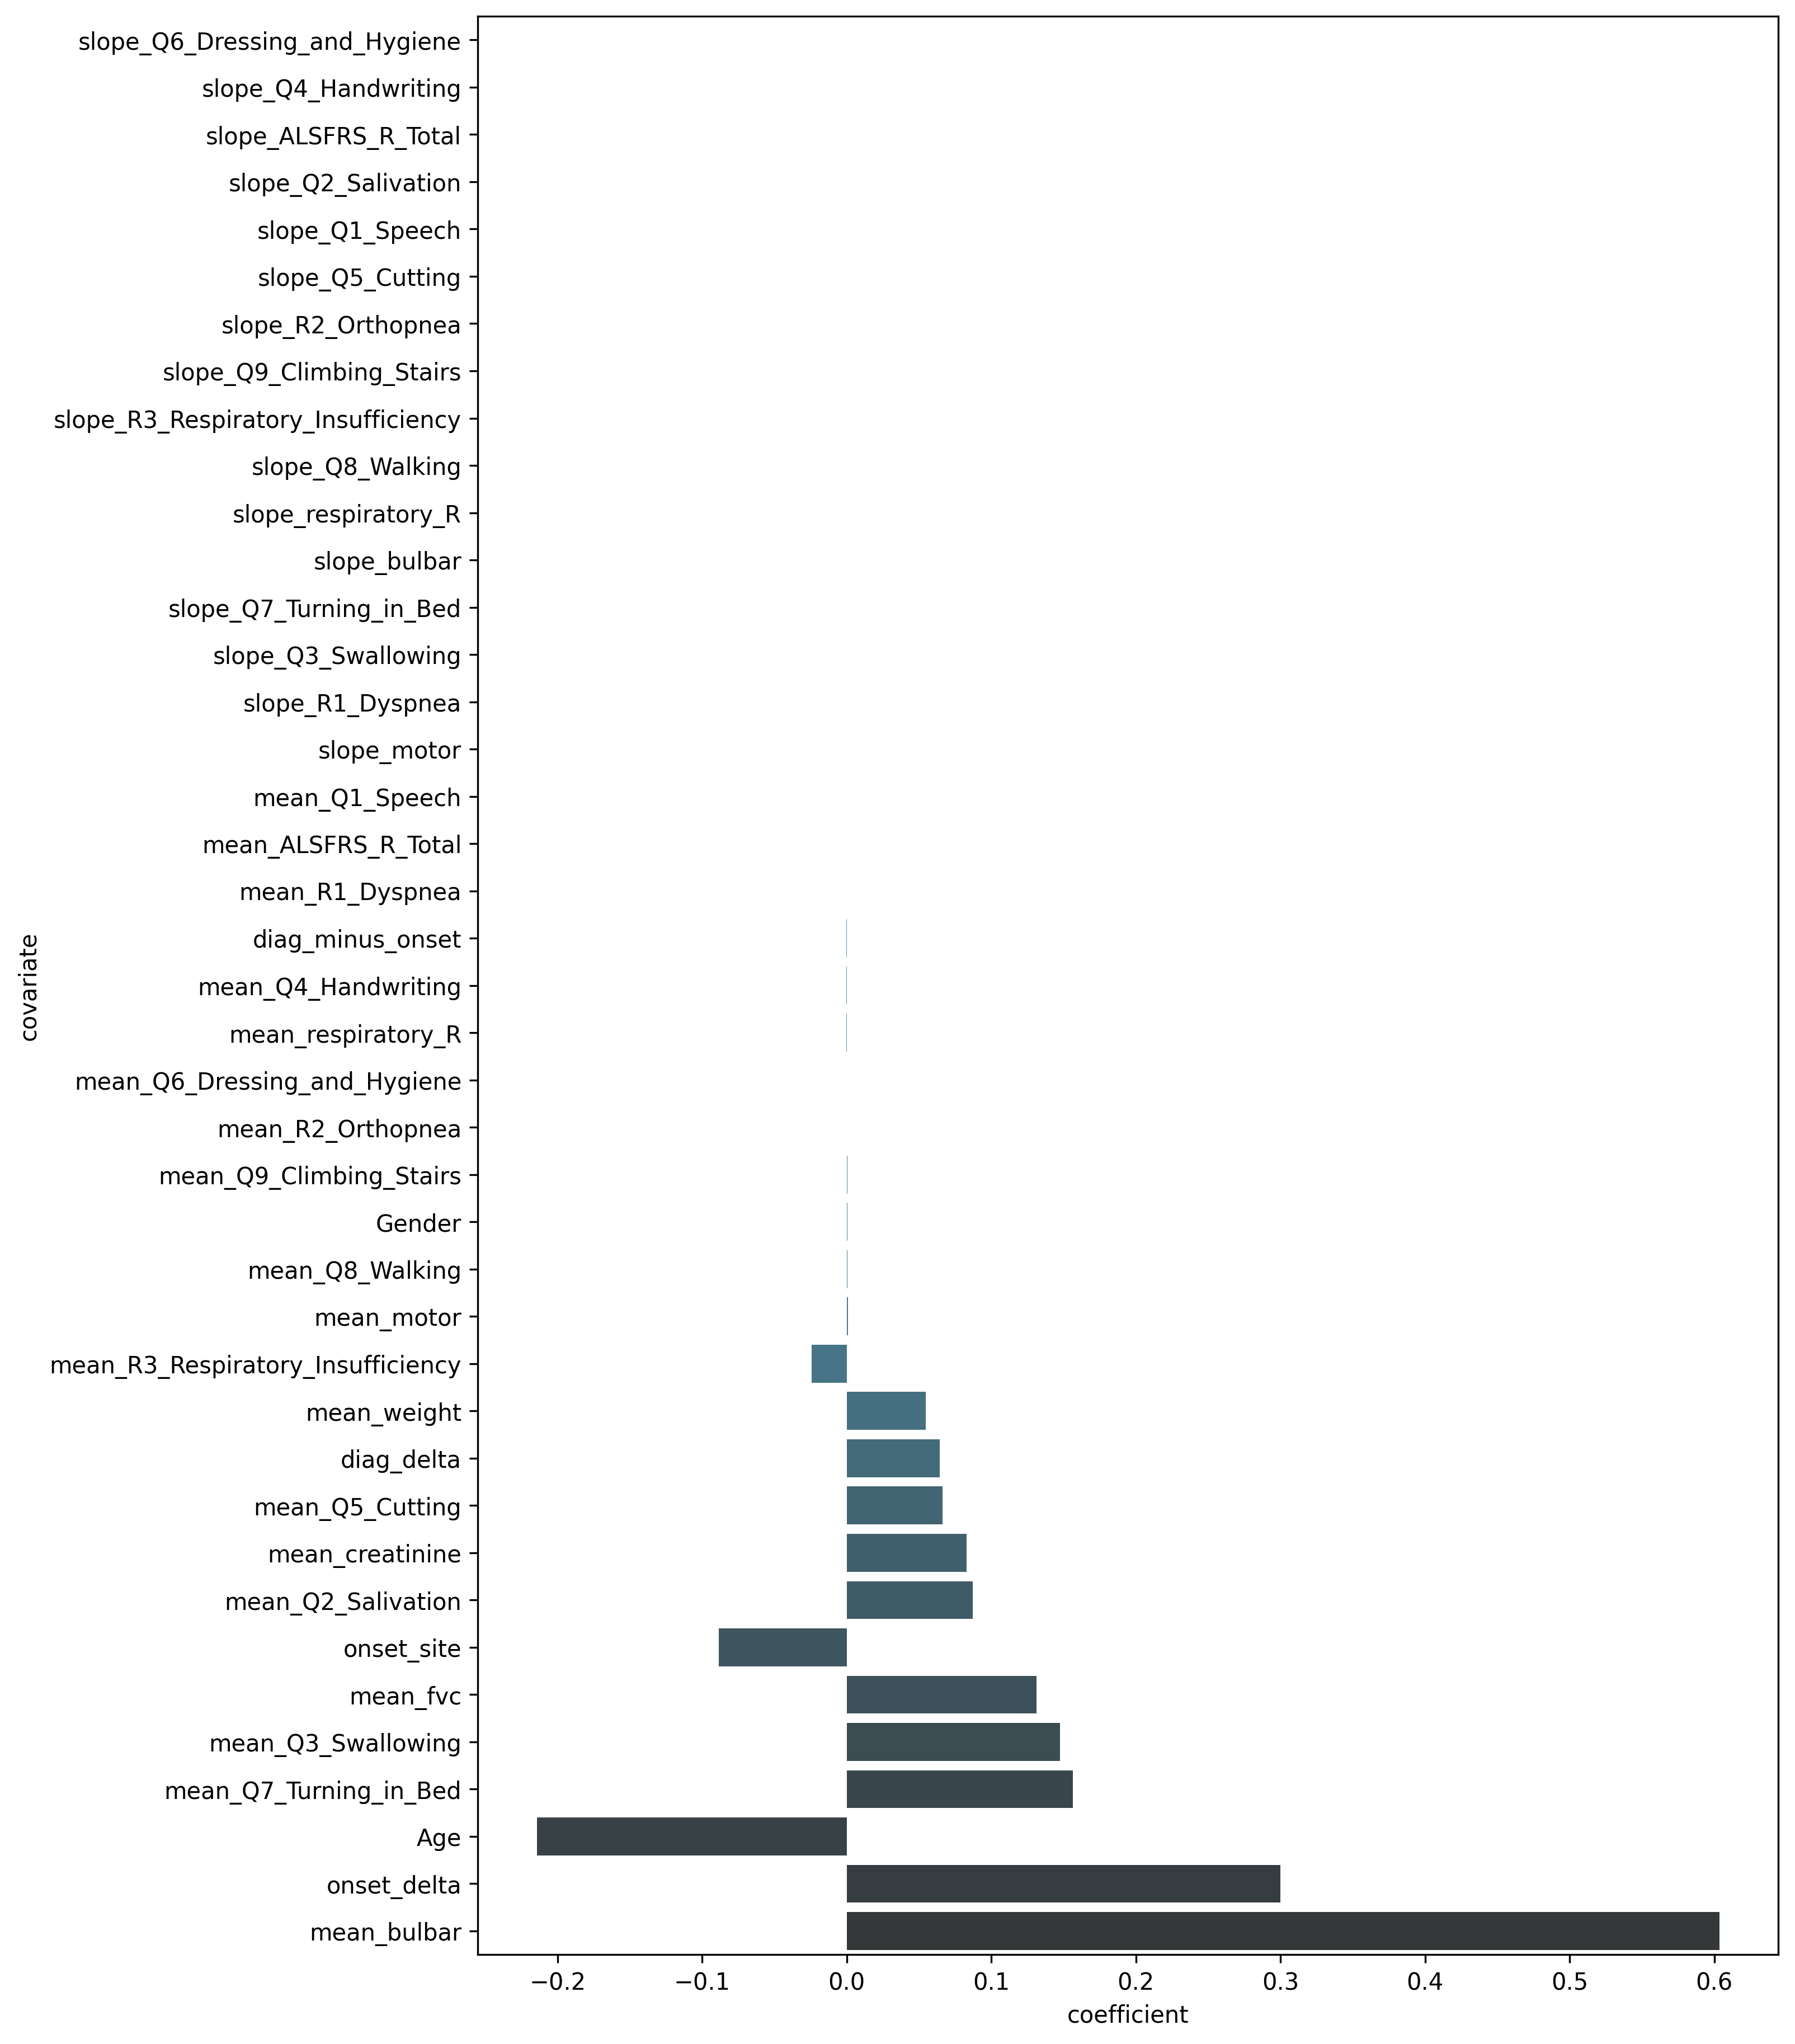

In [ ]:
# Plot coefficients in order of absolute value
df_aft_coef_absolute = df_aft_coef.copy()
sorted_index = np.abs(df_aft_coef_absolute['coefficient']).argsort()
df_aft_coef_absolute = df_aft_coef_absolute.iloc[sorted_index].reset_index(drop=True)

plt.figure(figsize=(10, 15))
sns.barplot(data=df_aft_coef_absolute, x='coefficient', y='covariate', orient='h', palette='GnBu_d')
plt.show()

In [ ]:
# Print coefficients with absolute value > 0.01
df_aft_coef_selected =df_aft_coef.query('(coefficient > 0.01) or (coefficient < -0.01)')
df_aft_coef_selected

covariate  coefficient
0                                 Age    -0.214231
24                         onset_site    -0.088612
16  mean_R3_Respiratory_Insufficiency    -0.024418
22                        mean_weight     0.054457
2                          diag_delta     0.064159
9                     mean_Q5_Cutting     0.066051
18                    mean_creatinine     0.083007
6                  mean_Q2_Salivation     0.087049
19                           mean_fvc     0.131247
7                  mean_Q3_Swallowing     0.147461
11             mean_Q7_Turning_in_Bed     0.156525
23                        onset_delta     0.299827
17                        mean_bulbar     0.603451

In [ ]:
# Features with |coefficient| <= 0.01 are excluded  (feature selection through lasso)
aft_final_feature_list = df_aft_coef_selected['covariate'].tolist()
print("Total " + str(len(aft_final_feature_list)) + " features are selected through lasso in AFT")
print(aft_final_feature_list)

Total 13 features are selected through lasso in AFT
['Age', 'onset_site', 'mean_R3_Respiratory_Insufficiency', 'mean_weight', 'diag_delta', 'mean_Q5_Cutting', 'mean_creatinine', 'mean_Q2_Salivation', 'mean_fvc', 'mean_Q3_Swallowing', 'mean_Q7_Turning_in_Bed', 'onset_delta', 'mean_bulbar']


In [ ]:
# Fit model with selected hyperparameter and features & print summary
aft = WeibullAFTFitter(penalizer = 0.01, l1_ratio = 1)
aft.fit(df_for_featsel[aft_final_feature_list+['time_LOA', 'status_LOA']], duration_col='time_LOA', event_col='status_LOA', ancillary=False)

aft.print_summary() # Prints accelerated failure rate & p-value of each feature

<lifelines.WeibullAFTFitter: fitted with 3396 total observations, 2781 right-censored observations>
             duration col = 'time_LOA'
                event col = 'status_LOA'
                penalizer = 0.01
   number of observations = 3396
number of events observed = 615
           log-likelihood = -2532.12
         time fit was run = 2023-11-22 14:08:30 UTC

---
                                            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param   covariate                                                                                                                                 
lambda_ Age                                -0.22       0.80       0.04            -0.29            -0.14                 0.75                 0.87
        diag_delta                          0.06       1.06       0.05            -0.04             0.16                 0.97                 1.17
        mean_Q2_Salivation                  0.09       1.09       0.04             0.00             0.17                 1.00                 1.19
        mean_Q3_Swallowing                  0.13       1.14       0.08            -0.03             0.29                 0.97                 1.34
        mean_Q5_Cutting                     0.08       1.08       0.06            -0.03             0.19                 0.97                 1.21
        mean_Q7_Turning_in_Bed              0.14       1.15       0.07             0.01             0.27                 1.01                 1.31
        mean_R3_Respiratory_Insufficiency  -0.03       0.97       0.06            -0.15             0.10                 0.86                 1.10
        mean_bulbar                         0.62       1.87       0.09             0.46             0.79                 1.58                 2.21
        mean_creatinine                     0.09       1.09       0.04            -0.00             0.17                 1.00                 1.19
        mean_fvc                            0.13       1.14       0.04             0.05             0.21                 1.05                 1.23
        mean_weight                         0.05       1.05       0.03            -0.01             0.11                 0.99                 1.12
        onset_delta                         0.30       1.35       0.06             0.19             0.41                 1.21                 1.51
        onset_site                         -0.08       0.92       0.08            -0.25             0.08                 0.78                 1.08
        Intercept                           3.68      39.70       0.06             3.56             3.81                35.04                44.97
rho_    Intercept                           0.39       1.47       0.03             0.33             0.45                 1.39                 1.56

                                            cmp to     z      p   -log2(p)
param   covariate                                                         
lambda_ Age                                   0.00 -5.75 <0.005      26.76
        diag_delta                            0.00  1.25   0.21       2.25
        mean_Q2_Salivation                    0.00  1.98   0.05       4.38
        mean_Q3_Swallowing                    0.00  1.62   0.10       3.26
        mean_Q5_Cutting                       0.00  1.39   0.16       2.61
        mean_Q7_Turning_in_Bed                0.00  2.16   0.03       5.01
        mean_R3_Respiratory_Insufficiency     0.00 -0.44   0.66       0.60
        mean_bulbar                           0.00  7.28 <0.005      41.45
        mean_creatinine                       0.00  1.94   0.05       4.25
        mean_fvc                              0.00  3.28 <0.005       9.89
        mean_weight                           0.00  1.72   0.09       3.56
        onset_delta                           0.00  5.31 <0.005      23.13
        onset_site                            0.00 -1.00   0.32       1.65
   

##1-2. COX

### (1) Hyperparameter tuning with GridSearchCV

In [ ]:
# Hyperparameter tuning for lasso
from sklearn.model_selection import GridSearchCV

cox_params ={ 'penalizer': [1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 0.1, 0.15, 0.2, 0.35,0.5],
              'l1_ratio' : [1]  }

In [ ]:
# 1분 소요
from lifelines import CoxPHFitter
from lifelines.utils.sklearn_adapter import sklearn_adapter
from sklearn.model_selection import KFold

X_cox = df_for_featsel.drop(columns = 'time_LOA')
y_cox = df_for_featsel['time_LOA']

base_class = sklearn_adapter(CoxPHFitter, event_col = 'status_LOA')
cph = base_class()

grid_cv2 = GridSearchCV(cph, param_grid = cox_params, cv = KFold(n_splits = 3), n_jobs = 1)
grid_cv2.fit(X_cox, y_cox)

/usr/local/lib/python3.10/dist-packages/lifelines/fitters/coxph_fitter.py:1679: RuntimeWarning: overflow encountered in exp
  scores = weights * exp(dot(X, beta))
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/coxph_fitter.py:1733: RuntimeWarning: invalid value encountered in multiply
  a1 = risk_phi_x_x * denom
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/coxph_fitter.py:1735: RuntimeWarning: invalid value encountered in multiply
  summand = numer * denom[:, None]
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/coxph_fitter.py:1740: RuntimeWarning: divide by zero encountered in log
  log_lik = log_lik + dot(x_death_sum, beta) + weighted_average * log(denom).sum()
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/coxph_fitter.py:1700: RuntimeWarning: invalid value encountered in add
  risk_phi_x = risk_phi_x + phi_x_i
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/coxph_fitter.py:1701: RuntimeWarning: invalid value encountered in add

GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
             estimator=SkLearnCoxPHFitter(baseline_estimation_method='breslow',
                                          breakpoints=None, knots=None,
                                          l1_ratio=0.0, n_baseline_knots=None,
                                          penalizer=0.0, strata=None),
             n_jobs=1,
             param_grid={'l1_ratio': [1],
                         'penalizer': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05,
                                       0.1, 0.15, 0.2, 0.35, 0.5]})

In [ ]:
# Result
print(grid_cv2.best_score_)  # 0.8433300225853996
print(grid_cv2.best_params_)  # {'l1_ratio': 1, 'penalizer': 0.01} is selected

0.8433300225853996
{'l1_ratio': 1, 'penalizer': 0.01}


In [ ]:
# Result
grid_cv2.cv_results_

{'mean_fit_time': array([ 3.4245464 ,  3.53881478,  3.52591038,  3.15409756,  6.56359315,
         6.49021967,  6.35075879,  8.89283737, 10.42440526,  5.45876026,
         5.64120078]),
 'std_fit_time': array([0.81529314, 1.57069189, 1.1194763 , 0.79760688, 1.19949674,
        1.33467068, 1.11000996, 3.08716262, 2.36974493, 1.26450625,
        1.38147127]),
 'mean_score_time': array([0.04203828, 0.        , 0.        , 0.        , 0.05767035,
        0.0664235 , 0.07772954, 0.13658285, 0.1315523 , 0.06309803,
        0.05570451]),
 'std_score_time': array([0.05945111, 0.        , 0.        , 0.        , 0.00538475,
        0.01393552, 0.02889521, 0.09692333, 0.02527604, 0.01322425,
        0.00068837]),
 'param_l1_ratio': masked_array(data=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False],
        fill_value='?',
             dtype=object),
 'param_penalizer': masked_array(data=[0.0001

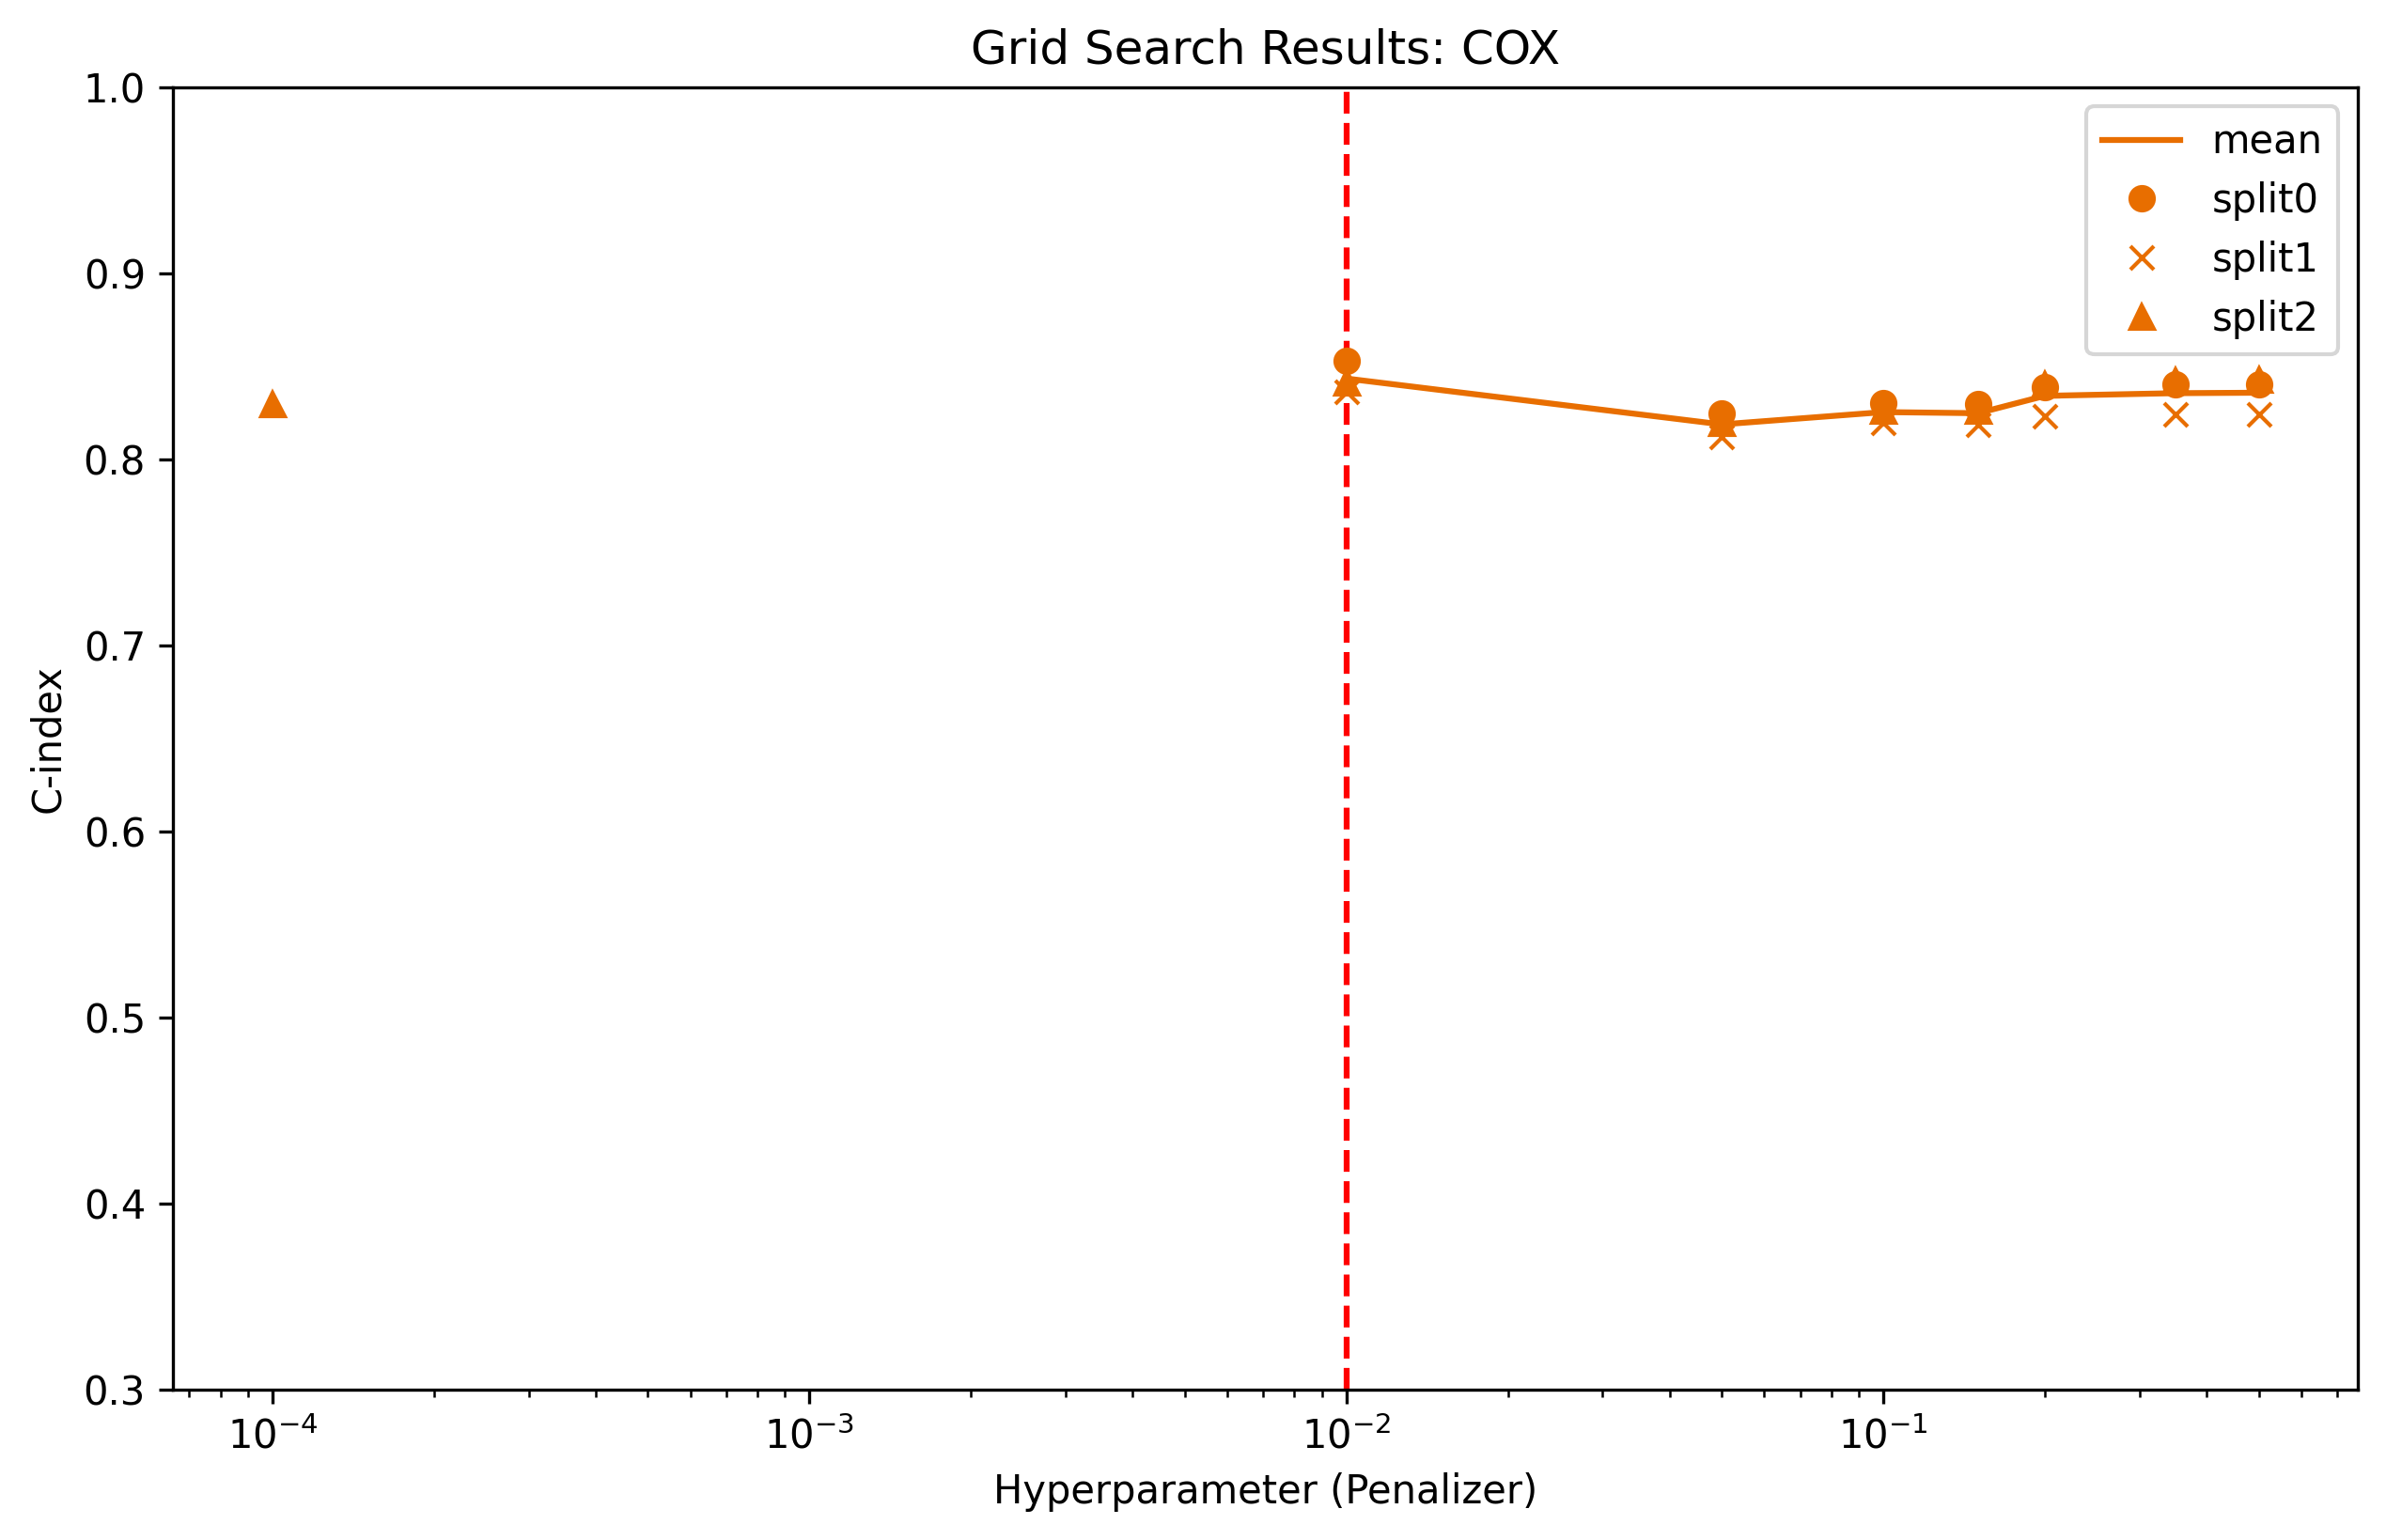

In [ ]:
# Plot the results
cv_results = grid_cv2.cv_results_
cv_results['param_penalizer'] = np.asarray(cv_results['param_penalizer'])

# Remove NaN values
valid0 = ~np.isnan(cv_results['split0_test_score'])
valid1 = ~np.isnan(cv_results['split1_test_score'])
valid2 = ~np.isnan(cv_results['split2_test_score'])

fig, ax = plt.subplots(figsize=(10, 6))
ax.axvline(x=0.01, color='red', linestyle='--')  # Penalizer = 0.01 showed best score

# Drop the indices with NaN values in any splits (indices 0, 1, 2, 3)
drop_indices = [0, 1, 2, 3]
ax.plot(pd.DataFrame(cv_results)['param_penalizer'].drop(index=drop_indices),
        pd.DataFrame(cv_results)[['split0_test_score', 'split1_test_score', 'split2_test_score']].mean(axis=1, skipna=True).drop(index=drop_indices),
        '-', label='mean', color='#E86E00')

ax.plot(cv_results['param_penalizer'][valid0], cv_results['split0_test_score'][valid0], 'o', label='split0', color='#E86E00')
ax.plot(cv_results['param_penalizer'][valid1], cv_results['split1_test_score'][valid1], 'x', label='split1', color='#E86E00')
ax.plot(cv_results['param_penalizer'][valid2], cv_results['split2_test_score'][valid2], '^', label='split2', color='#E86E00')

ax.set_xscale('log')
ax.set_xlabel('Hyperparameter (Penalizer)')
ax.set_ylabel('C-index')
ax.set_title('Grid Search Results: COX')
plt.ylim([0.3, 1.0])
plt.legend()
plt.show()

### (2) Feature selection with Lasso

In [ ]:
# Fit model with selected hyperparameter & print summary
from lifelines import CoxPHFitter
cph = CoxPHFitter(penalizer=0.01, l1_ratio = 1)
cph.fit(df_for_featsel, 'time_LOA', event_col='status_LOA')
cph.print_summary() # Prints hazard ratio & p-value of each feature

<lifelines.CoxPHFitter: fitted with 3396 total observations, 2781 right-censored observations>
             duration col = 'time_LOA'
                event col = 'status_LOA'
                penalizer = 0.01
                 l1 ratio = 1
      baseline estimation = breslow
   number of observations = 3396
number of events observed = 615
   partial log-likelihood = -4067.43
         time fit was run = 2023-11-22 14:33:29 UTC

---
                                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                  
Age                                  0.29       1.33       0.06             0.17             0.40                 1.19                 1.49
diag_delta                          -0.06       0.94       0.07            -0.20             0.08                 0.82                 1.09
onset_delta                         -0.43       0.65       0.08            -0.59            -0.26                 0.56                 0.77
diag_minus_onset                     0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
mean_Q1_Speech                      -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
mean_Q2_Salivation                  -0.11       0.89       0.07            -0.25             0.02                 0.78                 1.02
mean_Q3_Swallowing                  -0.18       0.84       0.12            -0.42             0.06                 0.66                 1.07
mean_Q4_Handwriting                 -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
mean_Q6_Dressing_and_Hygiene        -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
mean_Q7_Turning_in_Bed              -0.16       0.86       0.14            -0.42             0.11                 0.66                 1.12
mean_Q8_Walking                     -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
mean_Q9_Climbing_Stairs              0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
mean_ALSFRS_R_Total                 -0.06       0.94       0.15            -0.35             0.22                 0.70                 1.25
mean_R1_Dyspnea                      0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
mean_R2_Orthopnea                   -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
mean_R3_Respiratory_Insufficiency    0.02       1.02       0.10            -0.17             0.22                 0.84                 1.24
mean_Q5_Cutting                     -0.05       0.95       0.11            -0.27             0.16                 0.77                 1.17
mean_bulbar                         -0.92       0.40       0.13            -1.17            -0.66                 0.31                 0.52
mean_motor                          -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
mean_respiratory_R                   0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
slope_Q1_Speech                      0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
slope_Q2_Salivation                 -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
slope_Q3_Swallowing                 -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
slope_Q4_Handwriting                -0.00       1.00       0.00    

In [ ]:
# Print coefficients in order of size
cph_coef = cph.params_.copy()
df_cph_coef = pd.DataFrame(cph_coef)
df_cph_coef.columns = ['coefficient']
df_cph_coef.reset_index(inplace=True)
df_cph_coef.sort_values(by='coefficient', ascending=True, inplace=True)
df_cph_coef

covariate   coefficient
17                         mean_bulbar -9.158577e-01
2                          onset_delta -4.257687e-01
6                   mean_Q3_Swallowing -1.758457e-01
36                            mean_fvc -1.702888e-01
9               mean_Q7_Turning_in_Bed -1.550891e-01
5                   mean_Q2_Salivation -1.145496e-01
37                     mean_creatinine -9.759656e-02
38                         mean_weight -7.095321e-02
12                 mean_ALSFRS_R_Total -6.326266e-02
1                           diag_delta -5.726500e-02
16                     mean_Q5_Cutting -5.252530e-02
39                              Gender -1.123977e-07
4                       mean_Q1_Speech -8.809797e-08
18                          mean_motor -8.542724e-08
7                  mean_Q4_Handwriting -7.764313e-08
10                     mean_Q8_Walking -6.946403e-08
8         mean_Q6_Dressing_and_Hygiene -5.055079e-08
14                   mean_R2_Orthopnea -2.684819e-08
25             slope_Q7_Turning_in_Bed -1.251435e-16
22                 slope_Q3_Swallowing -1.621323e-21
21                 slope_Q2_Salivation -5.061164e-22
33                        slope_bulbar -1.354388e-22
30                  slope_R2_Orthopnea -1.014659e-22
27            slope_Q9_Climbing_Stairs -7.872636e-23
31  slope_R3_Respiratory_Insufficiency -5.791672e-23
23                slope_Q4_Handwriting -8.088635e-31
24       slope_Q6_Dressing_and_Hygiene  2.154325e-29
28                slope_ALSFRS_R_Total  5.073737e-23
32                    slope_Q5_Cutting  8.325349e-23
20                     slope_Q1_Speech  2.865848e-22
26                    slope_Q8_Walking  7.105213e-22
35                 slope_respiratory_R  4.068290e-18
34                         slope_motor  1.337543e-16
29                    slope_R1_Dyspnea  2.811140e-16
11             mean_Q9_Climbing_Stairs  1.151715e-08
3                     diag_minus_onset  2.442395e-08
19                  mean_respiratory_R  2.890399e-08
13                     mean_R1_Dyspnea  3.660062e-08
15   mean_R3_Respiratory_Insufficiency  2.364589e-02
40                          onset_site  1.063872e-01
0                                  Age  2.862056e-01

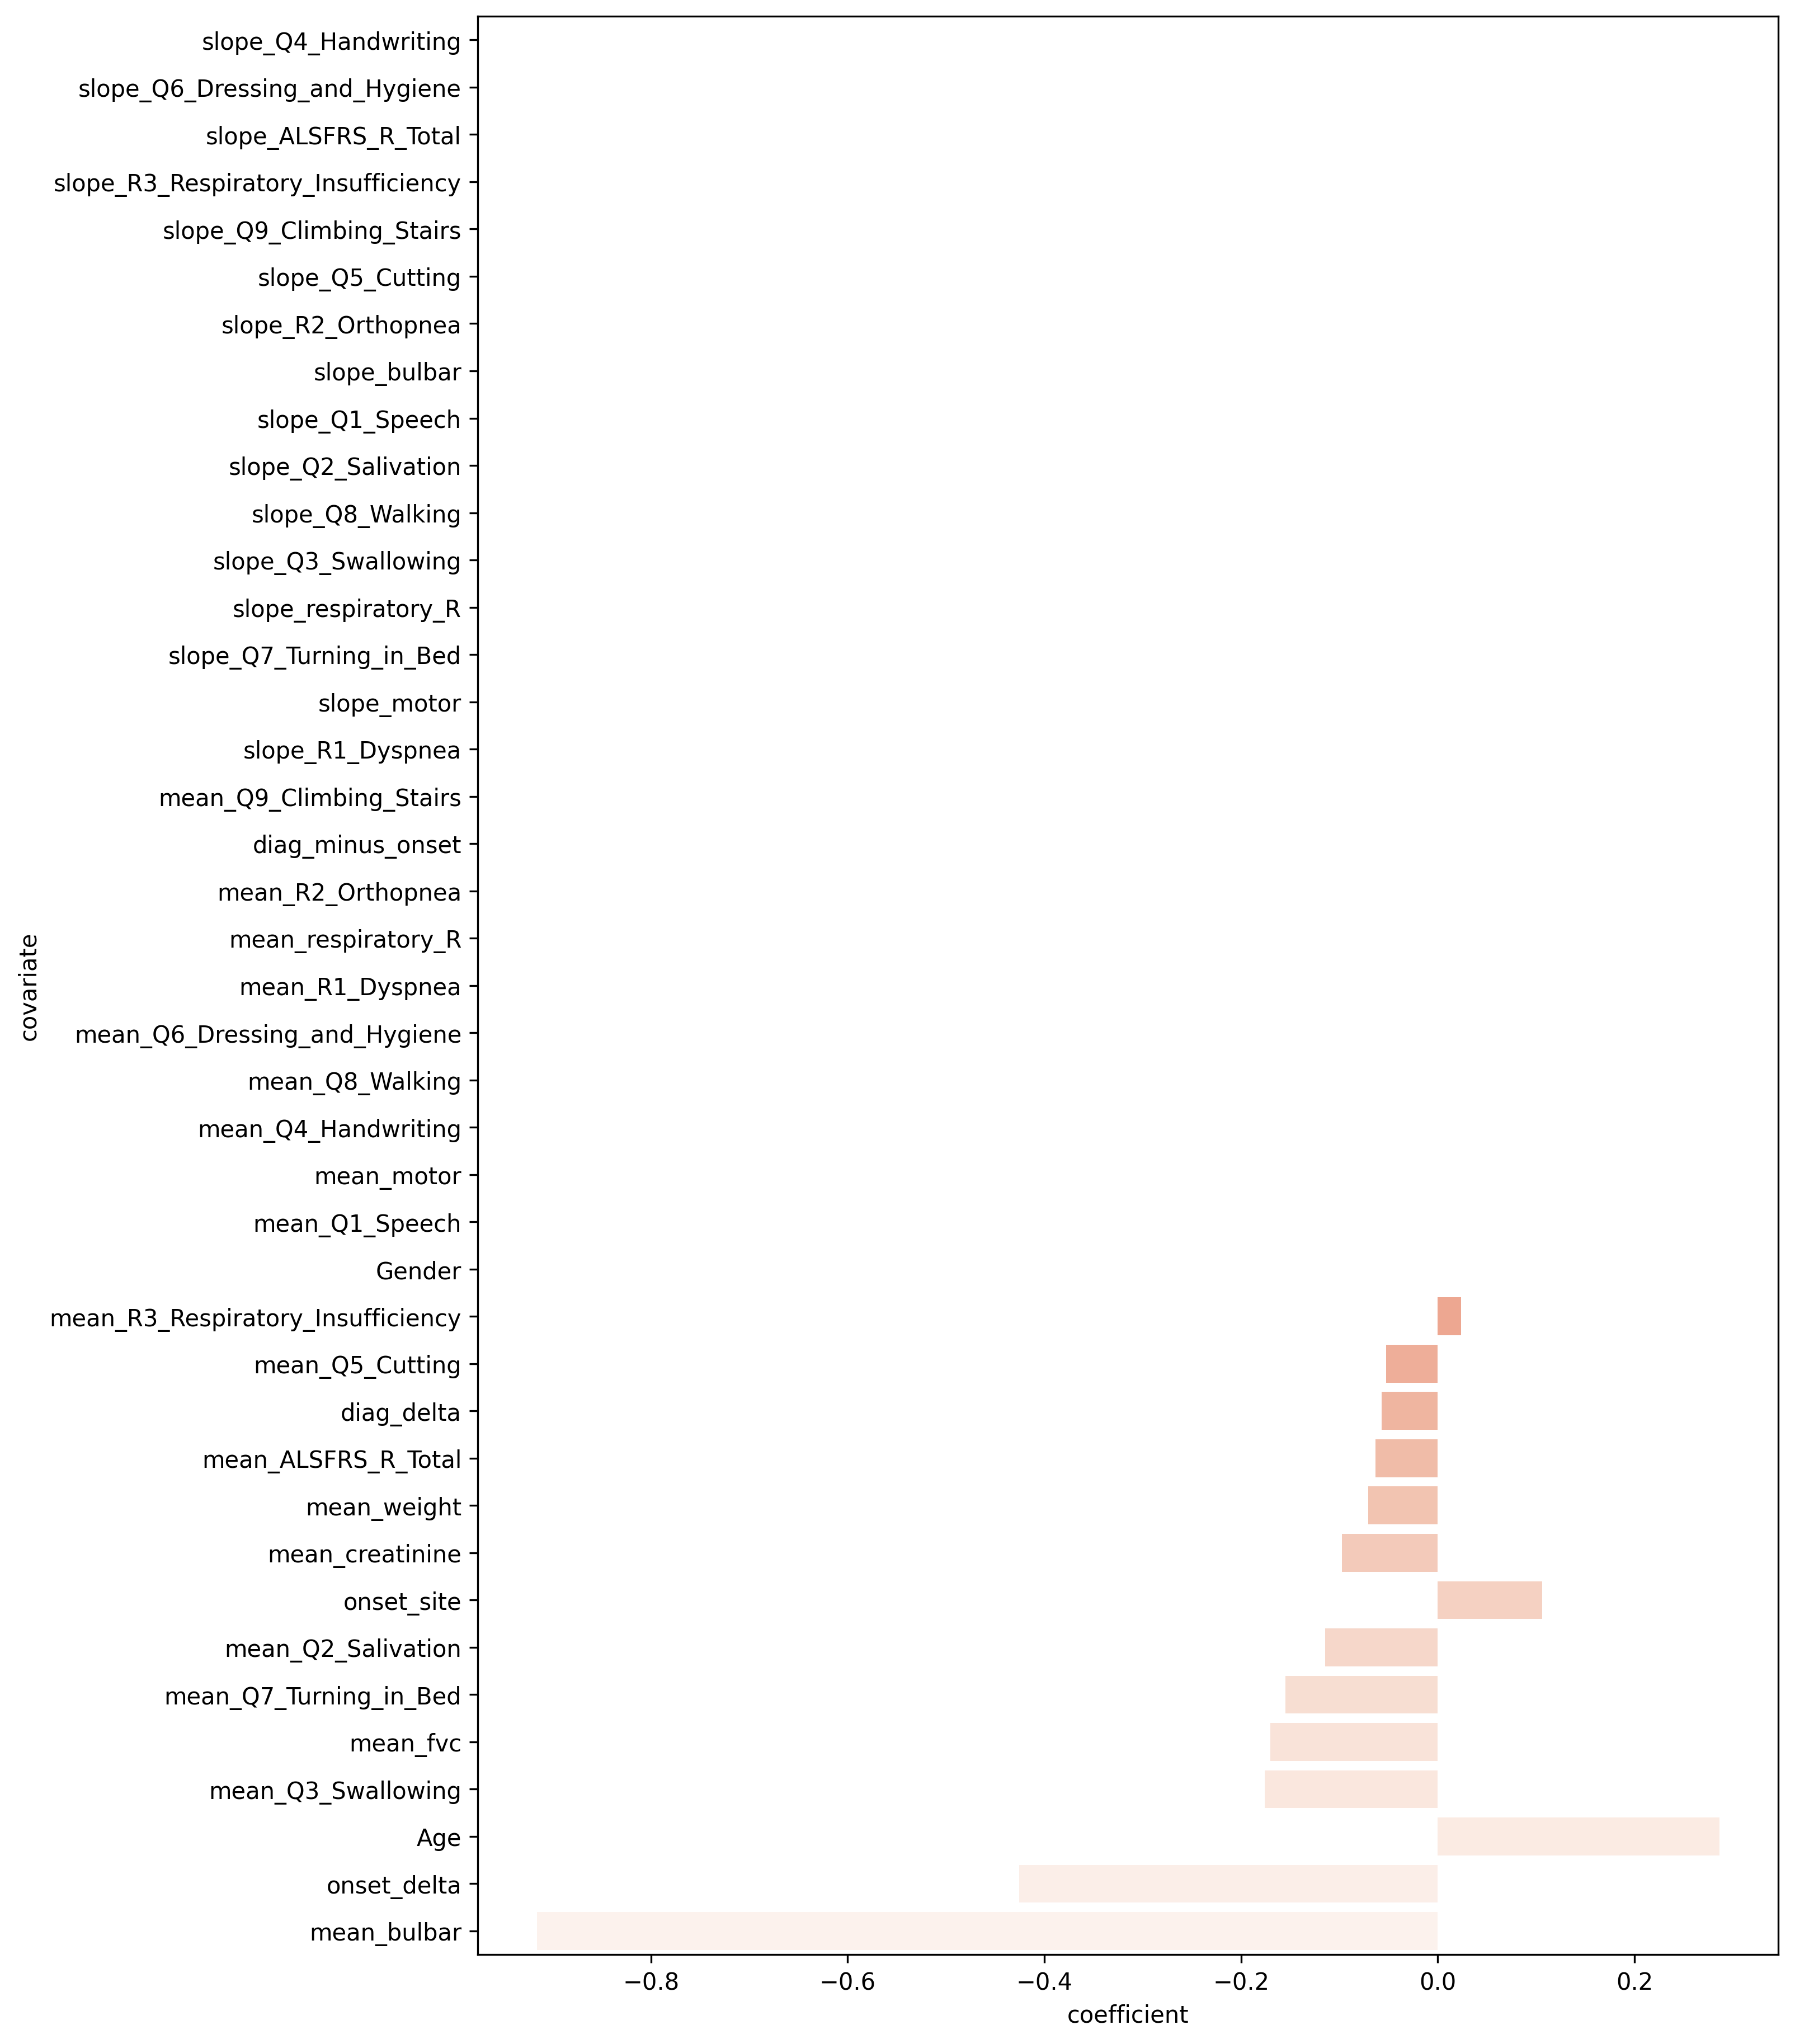

In [ ]:
# Plot coefficients in order of absolute value
df_cph_coef_absolute = df_cph_coef.copy()
sorted_index = np.abs(df_cph_coef_absolute['coefficient']).argsort()
df_cph_coef_absolute = df_cph_coef_absolute.iloc[sorted_index].reset_index(drop=True)

plt.figure(figsize=(10, 15))
sns.barplot(data=df_cph_coef_absolute, x='coefficient', y='covariate', orient='h', palette="Reds_r")
plt.show()

In [ ]:
# Print coefficients with absolute value > 0.01
df_cph_coef_selected =df_cph_coef.query('(coefficient > 0.01) or (coefficient < -0.01)')
df_cph_coef_selected

covariate  coefficient
17                        mean_bulbar    -0.915858
2                         onset_delta    -0.425769
6                  mean_Q3_Swallowing    -0.175846
36                           mean_fvc    -0.170289
9              mean_Q7_Turning_in_Bed    -0.155089
5                  mean_Q2_Salivation    -0.114550
37                    mean_creatinine    -0.097597
38                        mean_weight    -0.070953
12                mean_ALSFRS_R_Total    -0.063263
1                          diag_delta    -0.057265
16                    mean_Q5_Cutting    -0.052525
15  mean_R3_Respiratory_Insufficiency     0.023646
40                         onset_site     0.106387
0                                 Age     0.286206

In [ ]:
# Features with |coefficient| <= 0.01 are excluded  (feature selection through lasso)
cph_final_feature_list = df_cph_coef_selected['covariate'].tolist()
print("Total " + str(len(cph_final_feature_list)) + " features are selected through lasso in COX")
print(cph_final_feature_list)

Total 14 features are selected through lasso in COX
['mean_bulbar', 'onset_delta', 'mean_Q3_Swallowing', 'mean_fvc', 'mean_Q7_Turning_in_Bed', 'mean_Q2_Salivation', 'mean_creatinine', 'mean_weight', 'mean_ALSFRS_R_Total', 'diag_delta', 'mean_Q5_Cutting', 'mean_R3_Respiratory_Insufficiency', 'onset_site', 'Age']


##1-3. RSF

### (1) Hyperparmeter tuning with GridSearchCV

In [ ]:
# Random Survival Forests requires array-type data, thus additional preprocessing was needed
dic = {1:True, 0:False}

df_train_rsf = df_for_featsel_rsf.iloc[:, -2:][['status_LOA', 'time_LOA']]
df_train_rsf = df_train_rsf.replace({'status_LOA':dic})

In [ ]:
arr_1 = list(tuple(x) for x in df_train_rsf.to_records(index=False))
dt = np.dtype('bool, float')
y_train_rsf = np.array(arr_1, dtype=dt)
y_train_rsf.dtype.names=['cens', 'time']
y_train_rsf

array([(False, 10.18), ( True,  6.44), (False,  2.06), ...,
       (False, 10.78), (False,  3.05), (False,  1.14)],
      dtype=[('cens', '?'), ('time', '<f8')])

In [ ]:
#set hyperparameters values
params ={ 'n_estimators':[100],
          'max_features':['auto', 'sqrt','log2', None],
          'min_samples_leaf':[10,14,18],
          'min_samples_split':[8,12,16] }

In [ ]:
#CAUTION! Runtime takes about 1 hour 30 minutes
from sklearn.model_selection import KFold
rf = RandomSurvivalForest(random_state=20, n_jobs=-1)
grid_cv3 = GridSearchCV(rf, param_grid=params, cv=KFold(n_splits = 2), n_jobs=-1)
GG = grid_cv3.fit(df_for_featsel_rsf.iloc[:,:-2], y_train_rsf)

In [ ]:
grid_cv3.cv_results_

{'mean_fit_time': array([ 76.83575618,  70.97106743,  69.57425416,  69.11054039,
         63.32295942,  70.98359525,  60.32634926,  59.68942678,
         60.25884366,  71.46107876,  75.37688935,  71.87688494,
         63.48832428,  64.67267525,  65.52844489,  61.40414238,
         62.22725785,  60.65960753,  59.06720245,  59.29503775,
         59.12364733,  59.21914506,  55.54679656,  55.16657031,
         51.25201476,  52.59592497,  51.40619445, 517.66965306,
        516.38620579, 515.62855053, 466.12464416, 457.65886736,
        458.71077979, 415.87775922, 416.30222106, 409.56358588]),
 'std_fit_time': array([ 1.12528861,  1.59429693,  1.84518898,  0.50118756,  0.56056881,
         0.44991505,  0.29492807,  0.34936917,  0.89707065,  1.37681949,
         1.2810477 ,  1.91298962,  0.69537604,  0.3525821 ,  0.55406725,
         1.11120796,  0.85060918,  1.18150699,  0.41264999,  0.55064344,
         0.29567301,  0.08929443,  1.15711546,  0.83216918,  0.0503875 ,
         0.55220115,  1.

In [ ]:
# Result
print(grid_cv3.best_score_) # 0.8470778621021906
print(grid_cv3.best_params_) # {'max_features': 'auto', 'min_samples_leaf': 14 'min_samples_split': 8, 'n_estimators': 100} is selected

0.8470778621021906
{'max_features': 'auto', 'min_samples_leaf': 14, 'min_samples_split': 8, 'n_estimators': 100}


### (2) Feature selection with Permutation importance

In [ ]:
pip install eli5

In [ ]:
from sklearn.utils.metaestimators import available_if as if_delegate_has_method

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

In [ ]:
rsf_feature_list = df_for_featsel_rsf.columns.tolist()
remove_set = {'time_LOA', 'status_LOA'}

rsf_feature_list = [i for i in rsf_feature_list if i not in remove_set]

In [ ]:
#2분 소요
rsf = RandomSurvivalForest(n_estimators=100,
                           min_samples_split=8,
                           min_samples_leaf=14,
                           max_features="auto",
                           n_jobs=-1,
                           random_state=20)
rsf.fit(df_for_featsel_rsf[rsf_feature_list], y_train_rsf)

RandomSurvivalForest(max_features='auto', min_samples_leaf=14,
                     min_samples_split=8, n_jobs=-1, random_state=20)

In [ ]:
#26분 소요
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(rsf, n_iter=100, random_state=20)
perm.fit(df_for_featsel_rsf[rsf_feature_list], y_train_rsf)

PermutationImportance(estimator=RandomSurvivalForest(max_features='auto',
                                                     min_samples_leaf=14,
                                                     min_samples_split=8,
                                                     n_jobs=-1,
                                                     random_state=20),
                      n_iter=100, random_state=20)

<ipython-input-64-e90cd61a8cea>:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(data=df_sorted, ci=95, orient='h', palette='Greens_d' )


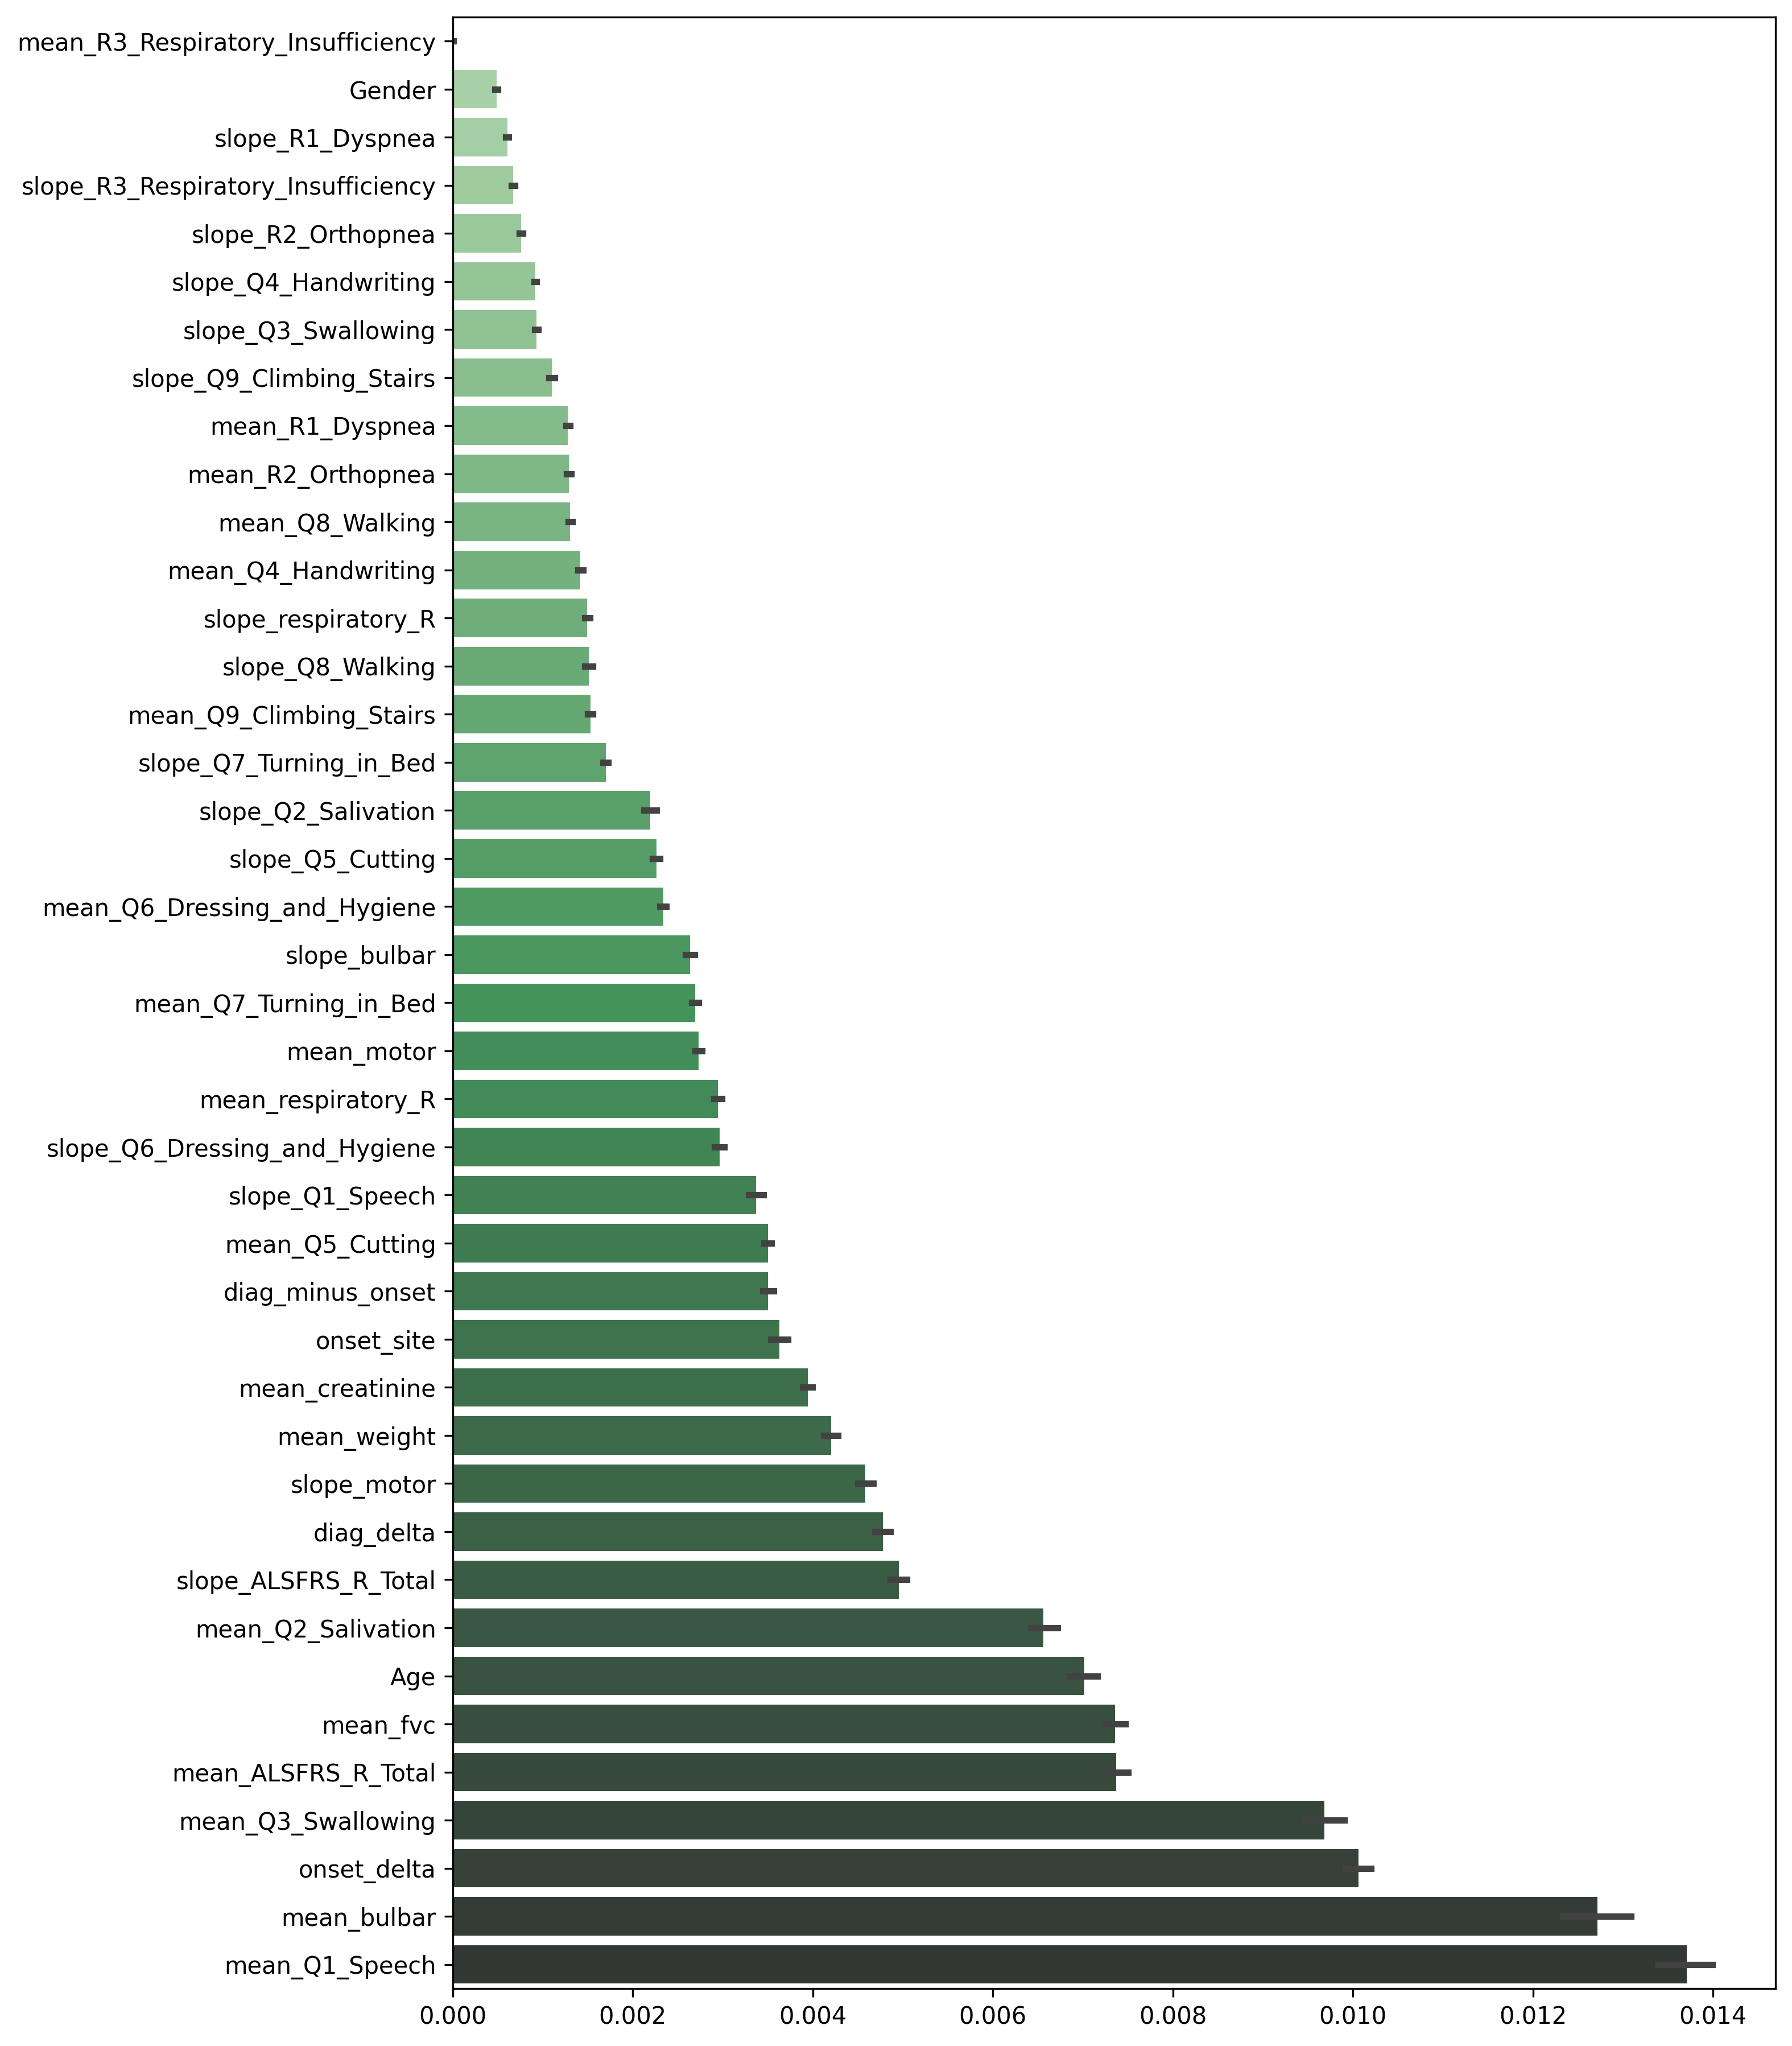

In [ ]:
data2 = perm.results_
df = pd.DataFrame(data2, columns=rsf_feature_list)
df_sorted = df.reindex(df.mean().sort_values().index, axis=1)

# Plot the data and the 95% CI intervals as error bars
plt.figure(figsize=(10, 15))
sns.barplot(data=df_sorted, ci=95, orient='h', palette='Greens_d' )
plt.show()

<ipython-input-65-ff3a3bbd7856>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(data=df_sorted, ci=95, orient='h', palette='Greens_d' )


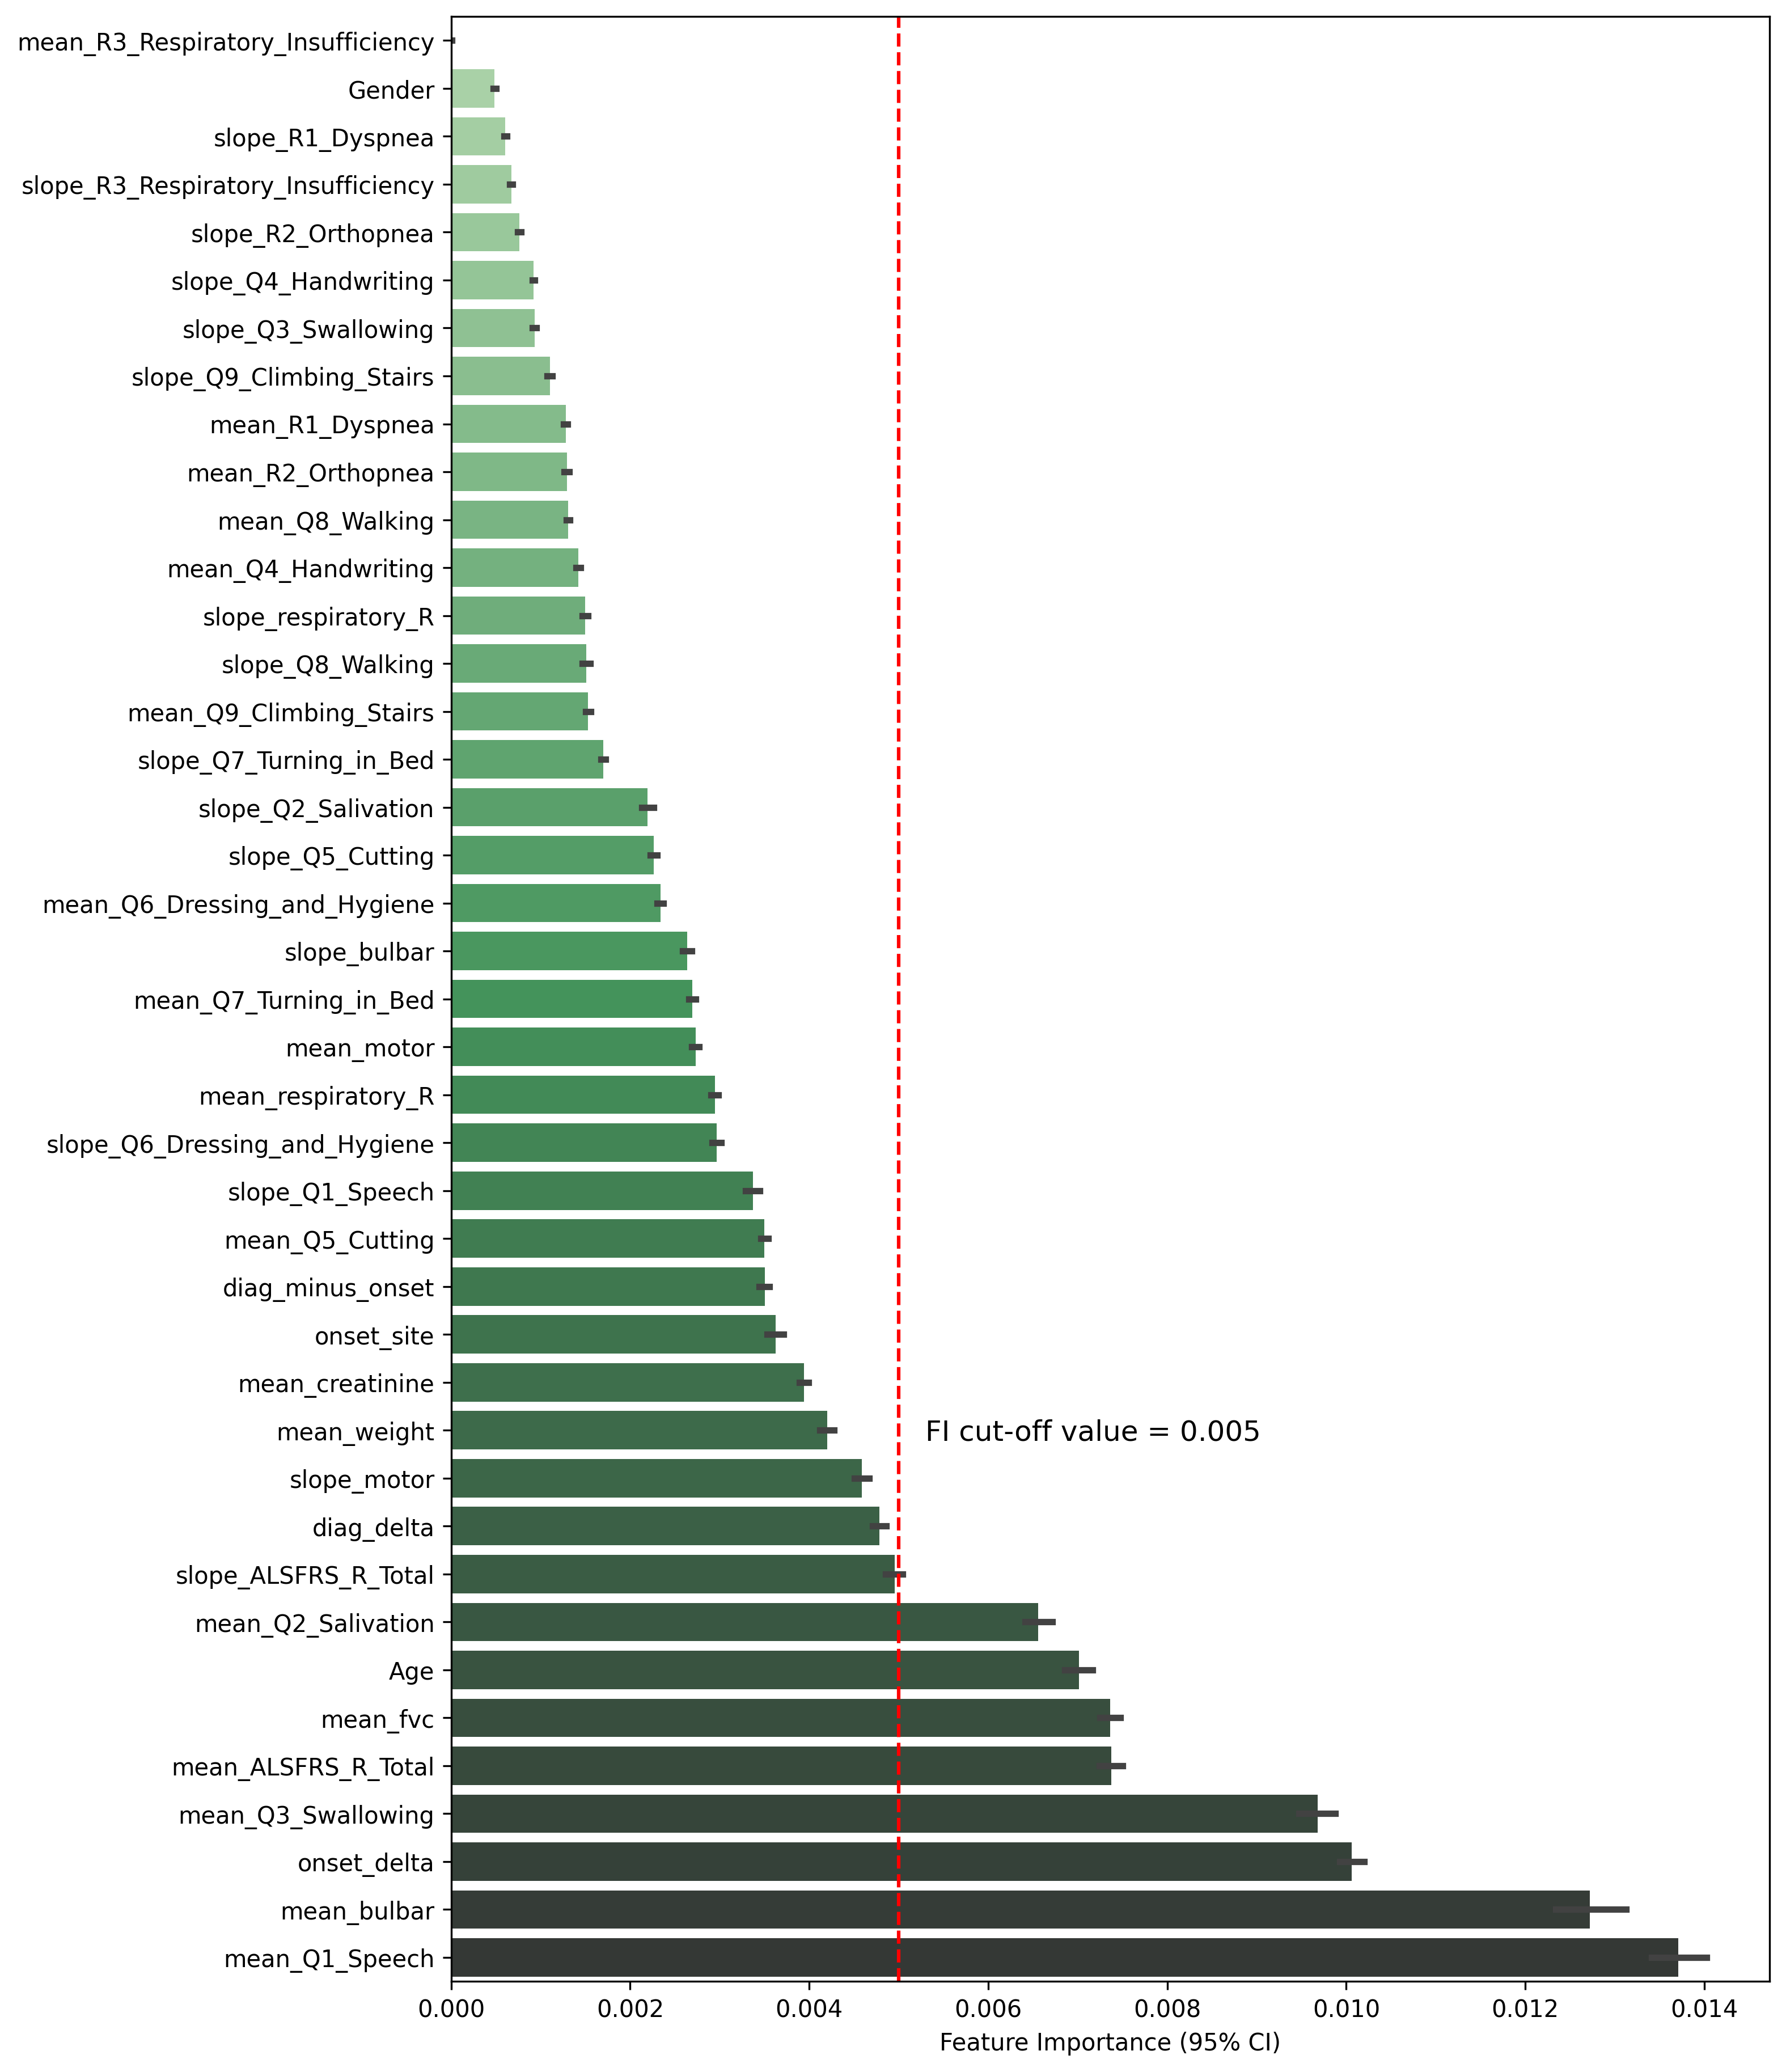

In [ ]:
# Plot the data and the 95% CI intervals as error bars
plt.figure(figsize=(10, 15))
sns.barplot(data=df_sorted, ci=95, orient='h', palette='Greens_d' )

plt.axvline(x=0.005, color='red', linestyle='--')
plt.annotate('FI cut-off value = 0.005', xy=(0.0053, 29.2), color='k', fontsize=12)
plt.xlabel('Feature Importance (95% CI)')

plt.show()

In [ ]:
#Calculate mean, std
mean = df_sorted.mean()
std = df_sorted.std()

# Calculate the 95% confidence intervals by group
interval = 1.96 * std / np.sqrt(len(df_sorted))

# Calculate the lower 95% CI
lower_95_CI = mean - interval
lower_95_CI

mean_R3_Respiratory_Insufficiency     6.216758e-07
Gender                                4.693479e-04
slope_R1_Dyspnea                      5.920378e-04
slope_R3_Respiratory_Insufficiency    6.570973e-04
slope_R2_Orthopnea                    7.441980e-04
slope_Q4_Handwriting                  9.040275e-04
slope_Q3_Swallowing                   9.096184e-04
slope_Q9_Climbing_Stairs              1.073460e-03
mean_R1_Dyspnea                       1.254252e-03
mean_R2_Orthopnea                     1.266929e-03
mean_Q8_Walking                       1.285770e-03
mean_Q4_Handwriting                   1.392258e-03
slope_respiratory_R                   1.464990e-03
slope_Q8_Walking                      1.467007e-03
mean_Q9_Climbing_Stairs               1.500765e-03
slope_Q7_Turning_in_Bed               1.673024e-03
slope_Q2_Salivation                   2.127928e-03
slope_Q5_Cutting                      2.221435e-03
mean_Q6_Dressing_and_Hygiene          2.301060e-03
slope_bulbar                   

In [ ]:
# feature selected based on permutation importance (lower 95% CI > 0.005)
rsf_final_feature_list = lower_95_CI[lower_95_CI>0.005].index.tolist()

print("Total " + str(len(rsf_final_feature_list)) + " features are selected through permutation importance in RSF")
print(rsf_final_feature_list)

Total 8 features are selected through permutation importance in RSF
['mean_Q2_Salivation', 'Age', 'mean_fvc', 'mean_ALSFRS_R_Total', 'mean_Q3_Swallowing', 'onset_delta', 'mean_bulbar', 'mean_Q1_Speech']


# 3. Finalize feature selection

In [ ]:
from matplotlib_venn import venn3_unweighted

In [ ]:
#Feature selection results
aft_final_feature_list = ['Age', 'onset_site', 'mean_R3_Respiratory_Insufficiency', 'mean_weight', 'diag_delta', 'mean_Q5_Cutting', 'mean_creatinine', 'mean_Q2_Salivation', 'mean_fvc', 'mean_Q3_Swallowing', 'mean_Q7_Turning_in_Bed', 'onset_delta', 'mean_bulbar']

cph_final_feature_list = ['mean_bulbar', 'onset_delta', 'mean_Q3_Swallowing', 'mean_fvc', 'mean_Q7_Turning_in_Bed', 'mean_Q2_Salivation', 'mean_creatinine', 'mean_weight', 'mean_ALSFRS_R_Total', 'diag_delta', 'mean_Q5_Cutting', 'mean_R3_Respiratory_Insufficiency', 'onset_site', 'Age']

rsf_final_feature_list = ['mean_Q2_Salivation', 'Age', 'mean_fvc', 'mean_ALSFRS_R_Total', 'mean_Q3_Swallowing', 'onset_delta', 'mean_bulbar', 'mean_Q1_Speech']

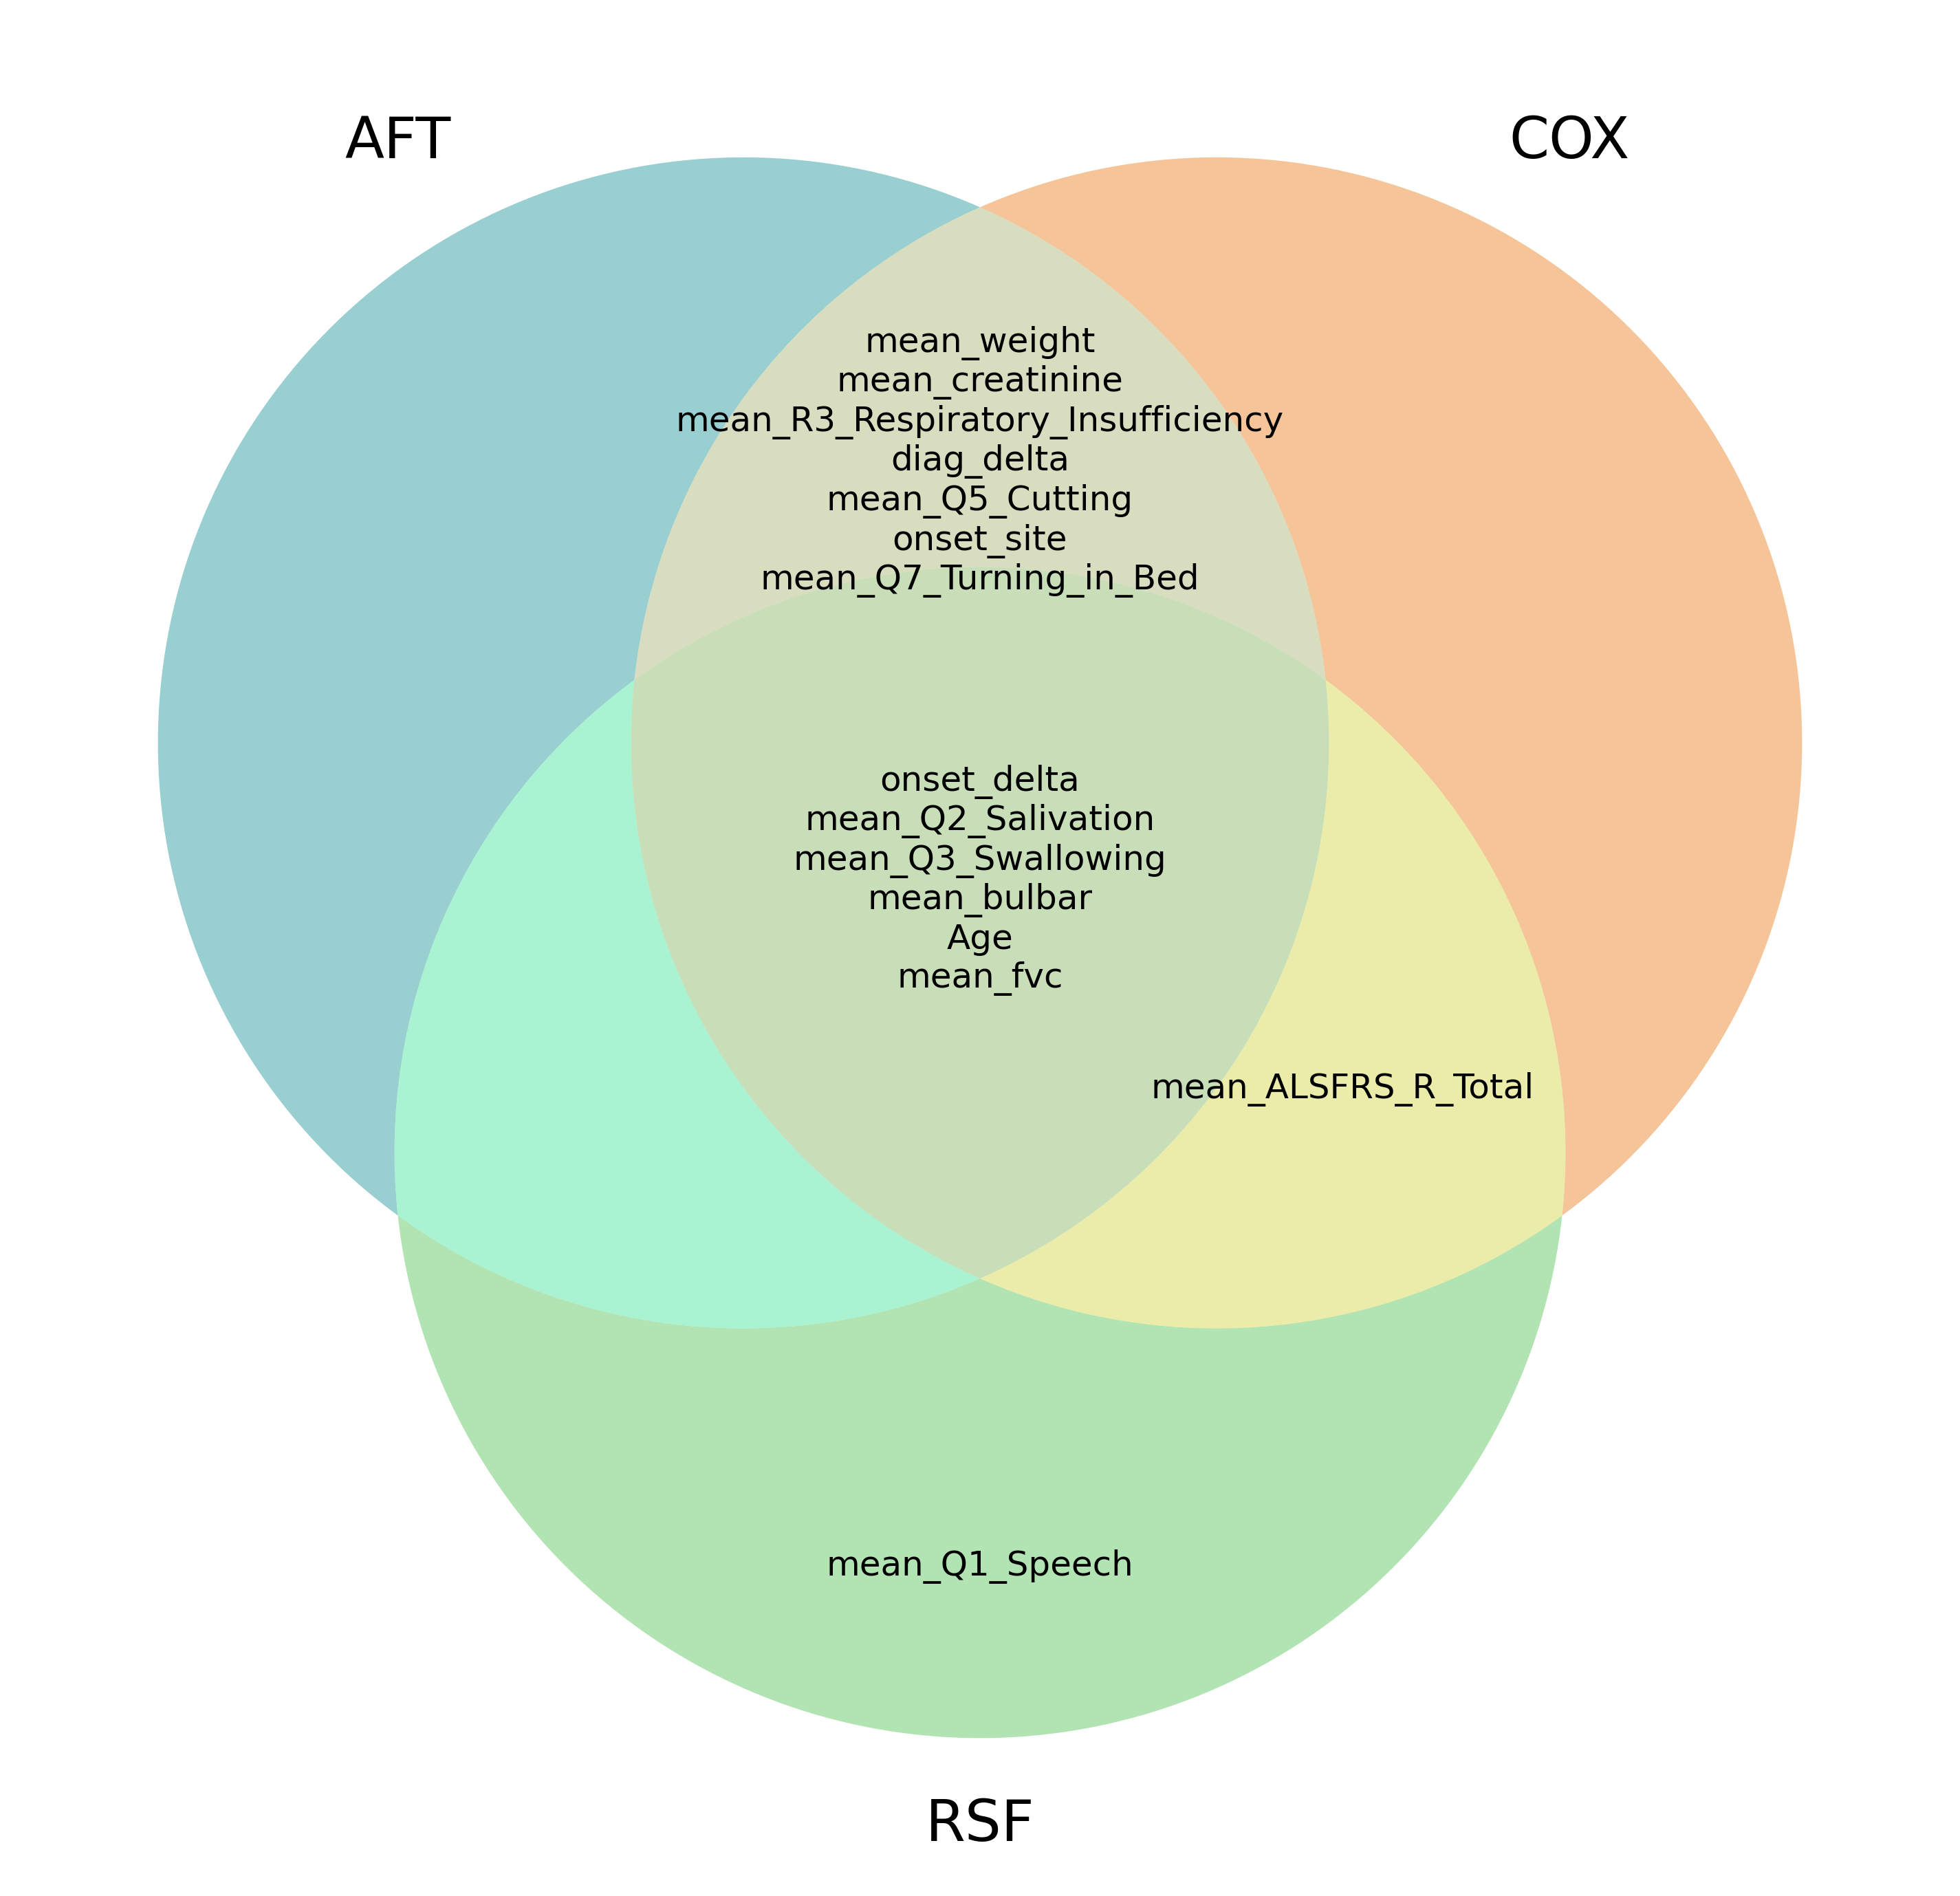

<Figure size 7500x7500 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3_unweighted

# Define 2 sets
A = set(aft_final_feature_list)
B = set(cph_final_feature_list)
C = set(rsf_final_feature_list)

# Create and instance of a venn diagram with 2 areas
plt.figure(figsize=(12,12))
diagram = venn3_unweighted([A, B, C], ("AFT", "COX", "RSF") ,set_colors= ('#00878E', '#E86E00', '#3FBB3F'))

# Set text content of areas
diagram.get_label_by_id("100").set_text("\n".join(A - B - C))
diagram.get_label_by_id("010").set_text("\n".join(B - A - C))
diagram.get_label_by_id("001").set_text("\n".join(C - B - A))
diagram.get_label_by_id("110").set_text("\n".join(A & B - C))
diagram.get_label_by_id("101").set_text("\n".join(A & C - B))
diagram.get_label_by_id("011").set_text("\n".join(C & B - A))
diagram.get_label_by_id("111").set_text("\n".join(A & B & C))

# Modify font sizes
for text in diagram.set_labels:
    text.set_fontsize(20)
for text in diagram.subset_labels:
    text.set_fontsize(12)

plt.figure(figsize=(25,25))
plt.show()

In [ ]:
all_features_selected = list(set(aft_final_feature_list) | set(cph_final_feature_list))
all_features_selected = list(set(all_features_selected) | set(rsf_final_feature_list))

In [ ]:
data2 = perm.results_
data = pd.DataFrame(data2, columns=rsf_feature_list)
data

Age    Gender  diag_delta  onset_delta  onset_site  diag_minus_onset  \
0   0.006304  0.000595    0.004316     0.008700    0.003656          0.003433   
1   0.006287  0.000429    0.005232     0.009800    0.003108          0.003946   
2   0.007024  0.000596    0.004415     0.009981    0.003596          0.003824   
3   0.006427  0.000450    0.004476     0.010281    0.003856          0.003161   
4   0.008196  0.000478    0.004662     0.010106    0.002831          0.003627   
..       ...       ...         ...          ...         ...               ...   
95  0.008188  0.000483    0.004900     0.009055    0.003834          0.003096   
96  0.007276  0.000480    0.004302     0.009858    0.004343          0.003359   
97  0.006374  0.000495    0.004762     0.009889    0.003269          0.003154   
98  0.007605  0.000495    0.004939     0.009188    0.004203          0.003734   
99  0.006069  0.000397    0.005067     0.009733    0.003793          0.003156   

    mean_Q1_Speech  mean_Q2_Salivation  mean_Q3_Swallowing  \
0         0.011587            0.006628            0.009292   
1         0.016157            0.005724            0.011908   
2         0.014316            0.007941            0.012668   
3         0.014838            0.006554            0.010155   
4         0.014223            0.005994            0.009303   
..             ...                 ...                 ...   
95        0.013643            0.007480            0.010202   
96        0.012817            0.007519            0.010546   
97        0.011311            0.007362            0.011356   
98        0.009869            0.006996            0.010769   
99        0.014993            0.005651            0.010661   

    mean_Q4_Handwriting  ...  slope_R1_Dyspnea  slope_R2_Orthopnea  \
0              0.001360  ...          0.000605            0.000789   
1              0.001466  ...          0.000683            0.000623   
2              0.001565  ...          0.000728            0.000704   
3              0.001364  ...          0.000570            0.000735   
4              0.001426  ...          0.000510            0.000837   
..                  ...  ...               ...                 ...   
95             0.001288  ...          0.000668            0.000771   
96             0.001132  ...          0.000582            0.000771   
97             0.001394  ...          0.000693            0.000662   
98             0.001700  ...          0.000624            0.000891   
99             0.001400  ...          0.000614            0.000825   

    slope_R3_Respiratory_Insufficiency  slope_Q5_Cutting  slope_bulbar  \
0                             0.000767          0.002349      0.002663   
1                             0.000666          0.002390      0.002422   
2                             0.000642          0.002381      0.002872   
3                             0.000622          0.002459      0.002617   
4                             0.000656          0.002349      0.002685   
..                                 ...               ...           ...   
95                            0.000566          0.002396      0.002604   
96                            0.000650          0.002518      0.002312   
97                            0.000678          0.002335      0.002275   
98                            0.000602          0.002130      0.002996   
99                            0.000664          0.002426      0.002662   

    slope_motor  slope_respiratory_R  mean_fvc  mean_creatinine  mean_weight  
0      0.003822             0.001492  0.007925         0.004021     0.003527  
1      0.004787             0.001474  0.007250         0.003715     0.003157  
2      0.005479             0.001647  0.006017         0.003773     0.004377  
3      0.004771             0.001366  0.007232         0.003827     0.004394  
4      0.004460             0.001685  0.009011         0.003877     0.004250  
..          ...                  ...       ...              ...          ...  
95     0

In [ ]:
means = data.mean()
means = means.sort_values(ascending=False)
data = data[means.index]
data = np.transpose(data)
data['50%'] = data.quantile(0.5, axis = 1)
data['75%'] = data.quantile(0.75, axis = 1)
data['25%'] = data.quantile(0.25, axis = 1)
data['std'] = data.std(axis=1)
data[['50%','75%','25%', 'std']]
Feat_imp = data[['50%','75%','25%']].transpose()
Feat_imp.columns = list(data.index)
Feat_imp_summary = data[['50%','75%','25%', 'std']].round(4).astype('str').copy()

In [ ]:
aft_logAFR = df_aft_coef[df_aft_coef['covariate'].isin(all_features_selected)]
aft_logAFR.columns = ['covariate', 'AFT']

cph_HR = df_cph_coef[df_cph_coef['covariate'].isin(all_features_selected)]
cph_HR.columns=['covariate', 'COX']

Feat_imp_df = Feat_imp_summary.reset_index()[['index', '50%']]
rsf_FI = Feat_imp_df[Feat_imp_df['index'].isin(all_features_selected)]
rsf_FI.columns=['covariate', 'RSF']

In [ ]:
params_compare_df = pd.merge(pd.merge(aft_logAFR,cph_HR, on='covariate', how='outer'), rsf_FI, on='covariate', how='outer').query("covariate != 'Intercept'")
order = ['onset_site', 'mean_bulbar', 'mean_Q1_Speech','mean_Q2_Salivation', 'mean_Q3_Swallowing', 'Age',
         'onset_delta', 'diag_delta', 'mean_fvc', 'mean_R3_Respiratory_Insufficiency', 'mean_creatinine',
         'mean_weight','mean_Q5_Cutting', 'mean_Q7_Turning_in_Bed', 'mean_ALSFRS_R_Total']
ordered_df = params_compare_df.set_index('covariate').reindex(order).reset_index()
ordered_df.astype('str')

covariate                     AFT  \
0                          onset_site    -0.08861163977193719   
1                         mean_bulbar      0.6034505602348035   
2                      mean_Q1_Speech   9.002054991627398e-09   
3                  mean_Q2_Salivation     0.08704898891913326   
4                  mean_Q3_Swallowing     0.14746089246049834   
5                                 Age    -0.21423093867612134   
6                         onset_delta      0.2998274272383768   
7                          diag_delta     0.06415851628540314   
8                            mean_fvc     0.13124658932106845   
9   mean_R3_Respiratory_Insufficiency   -0.024418328466171837   
10                    mean_creatinine     0.08300704282803331   
11                        mean_weight     0.05445678369432937   
12                    mean_Q5_Cutting     0.06605097077948538   
13             mean_Q7_Turning_in_Bed     0.15652500732905664   
14                mean_ALSFRS_R_Total  -4.403795933476847e-06   

                       COX     RSF  
0      0.10638715547047402  0.0037  
1      -0.9158577144163145  0.0128  
2   -8.809797097603986e-08   0.014  
3      -0.1145495928212558  0.0065  
4     -0.17584566525605455  0.0094  
5      0.28620559301928794  0.0071  
6     -0.42576871310755426  0.0101  
7     -0.05726499669006956  0.0048  
8     -0.17028882470489343  0.0074  
9     0.023645894837169123     0.0  
10    -0.09759656078707263  0.0039  
11    -0.07095321144244111  0.0042  
12    -0.05252530001282532  0.0035  
13     -0.1550890794045962  0.0027  
14    -0.06326265935121131  0.0075

In [ ]:
matplotlib.rcParams.update({'font.size': 13})

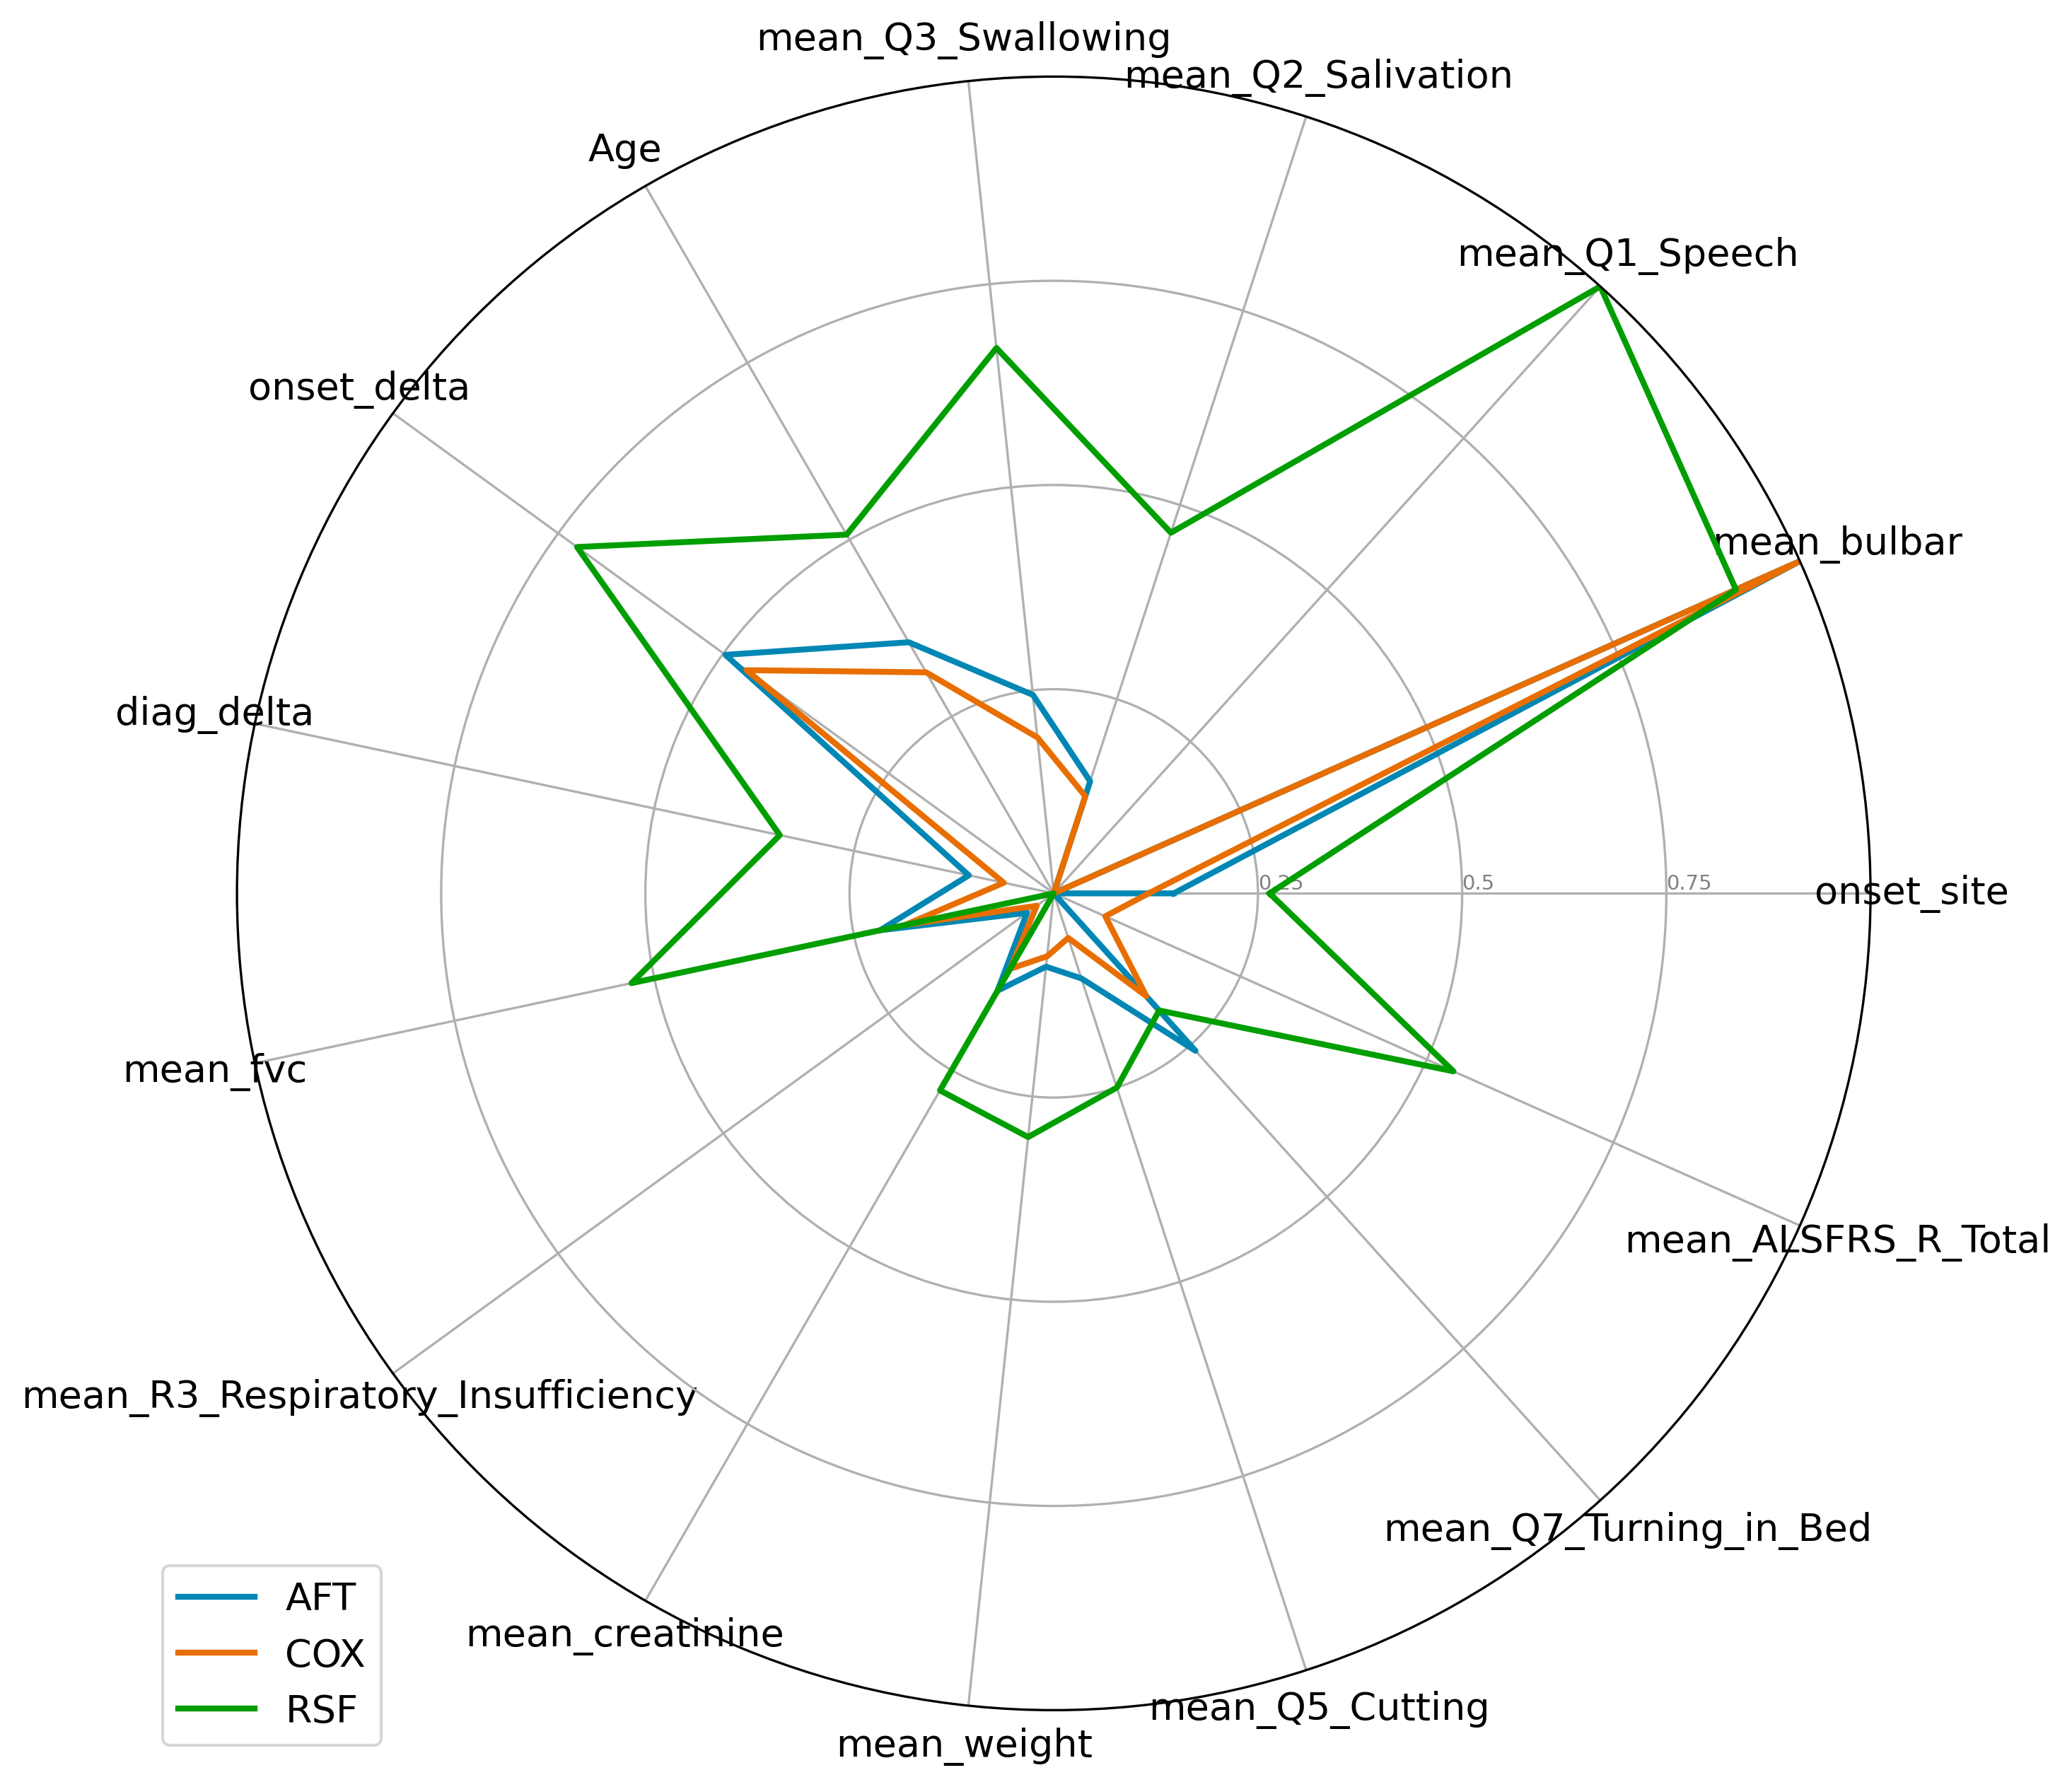

In [ ]:
from math import pi

# Data
df = ordered_df.astype('str')

# Convert numeric columns from string to float and handle NaN
df['AFT'] = pd.to_numeric(df['AFT'], errors='coerce')
df['COX'] = pd.to_numeric(df['COX'], errors='coerce')
df['RSF'] = pd.to_numeric(df['RSF'], errors='coerce')

# Independent standardization
max_values = df[['AFT', 'COX', 'RSF']].abs().max()
df_standardized = df[['AFT', 'COX', 'RSF']].abs() / max_values

# Replace NaN with 0 after standardization
df_standardized.fillna(0, inplace=True)

# Number of variables
categories = df['covariate']
N = len(categories)

# What will be the angle of each axis in the plot?
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Initialize the spider plot
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

# Draw one axe per variable and add labels
plt.xticks(angles[:-1], categories)

# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([0.25, 0.5, 0.75], ["0.25", "0.5", "0.75"], color="grey", size=7)
plt.ylim(0, 1)

# Plot each variable
for column, color in zip(['AFT', 'COX', 'RSF'], ['#0087B4', '#E86E00', '#009E00']):
    values = df_standardized[column].tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid', label=column)


# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

plt.show()